# Shear profile around A360 using ComCam HSM shapes - Manual

Prakruth Adari, Céline Combet, Anja von der Linden\
LSST Science Piplines version: Weekly 2025_30\
Container Size: large

This notebook goes over the necessary steps to create the source sample for the Abell 360 Weak Lensing project. A rough outline of the steps are:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Applying cuts (color/photo-z + lensing quality)
- Load in calibration (using the `gen_hsc_calibration` script)
- Shear profile

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.stats as stats
import healpy as hp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from astropy.visualization import make_lupton_rgb
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
from astropy.table import Table, join, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
# %matplotlib widget
import h5py
import qp

In [2]:
# Familiar stack packages
from lsst.daf.butler import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
# from lsst.afw.image import Exposure, Image, PARENT
import lsst.sphgeom

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage

In [3]:
# import lsst.afw.display as afwDisplay
import os, sys, gc
import functools
import pickle

In [4]:
# !pip install clmm

In [6]:
pip install clmm --user

  Using cached clmm-1.16.1-py3-none-any.whl.metadata (10 kB)
Using cached clmm-1.16.1-py3-none-any.whl (89 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

ModuleNotFoundError: No module named 'clmm'

In [10]:
hdir = os.getenv('HOME')
ddir = '/home/a/adari/DATA'
# outdir = '/home/a/adari/u/clusters/cluster_data'
outdir = '/global/cfs/cdirs/lsst/groups/CL/A360_DP1/source_selection_scratch/'

In [11]:
# Running at USDF RSP?
pz_sv38_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ecdfs_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
pz_sv38_pdf_dir = '/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/'
pz_ecdfs_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all'

# Running at NERSC?
pz_sv38_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_4band'
pz_ecdfs_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_6band'

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [13]:
def showRGB(image, bgr="gri", ax=None, fp=None, figsize=(8,8), stretch=57, Q=10):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    fp: `lsst.afw.detection.Footprint`
        Footprint that contains the peak catalog for peaks in the image.
        If `fp` is `None` then no peak positions are plotted.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,  # numpy array for the r channel
                          image_g=image[bgr[1]].array,  # numpy array for the g channel
                          image_b=image[bgr[0]].array,  # numpy array for the b channel
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = image[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    ax.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))
    if fp is not None:
        for peak in fp.getPeaks():
            ax.plot(peak.getIx(), peak.getIy(), "bx", mew=2)

In [14]:
# QOL Functions to make cubehelix colormaps

import matplotlib as mpl
import matplotlib.colors as mcolors


def _reverser(func, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    return func(1 - x)

def reversed(cmap):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_r = {
        key: (functools.partial(_reverser, data))
        for key, data in cmap._segmentdata.items()}

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_r,
        cmap.N,
        cmap._gamma,
    )

    # Reverse the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def _truncator(func, light, dark, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    if (light > 1) or (light < 0):
        raise ValueError(f"light {light} not in [0, 1]")
    if (dark > 1) or (dark < 0):
        raise ValueError(f"dark {dark} not in [0, 1]")

    return func(x * (light - dark) + dark)


def truncated(cmap, light, dark):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_t = {
        key: (functools.partial(_truncator, data, light, dark))
        for key, data in cmap._segmentdata.items()
    }

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_t,
        cmap.N,
        cmap._gamma,
    )

    # Truncate the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def cubehelix_colormap(
    *,
    start=None,
    rot=None,
    gamma=None,
    hue=None,
    light=1,
    dark=0,
    name=None,
    reverse=False,
):
    """
    cubehelix color scheme by Dave Green (https://people.phy.cam.ac.uk/dag9/CUBEHELIX/)
    """
    # Note: this relies on an internal matplotlib function, so may need to be
    # updated in the future
    cdict = mpl._cm.cubehelix(gamma=gamma, s=start, r=rot, h=hue)

    cmap = mcolors.LinearSegmentedColormap(name, cdict)

    cmap = truncated(cmap, light, dark)

    if reverse:
        cmap = reversed(cmap)

    return cmap

def cubehelix_palette(
    n_colors=6,
    start=0,
    rot=0.4,
    gamma=1.0,
    hue=0.8,
    light=0.85,
    dark=0.15,
    reverse=False,
):
    cmap = cubehelix_colormap(
        start=start,
        rot=rot,
        gamma=gamma,
        hue=hue,
        light=light,
        dark=dark,
        name=None,
        reverse=reverse,
    )

    x = np.linspace(0, 1, n_colors)
    palette = cmap(x)[:, :3].tolist()

    return palette

In [15]:
rng = np.random.default_rng()

In [16]:
arcsec = 1/60**2

In [17]:
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
C = 3e5 # km/s

In [18]:
Hz = lambda z : C/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [19]:
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

In [20]:
bands = list('griz')
cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]

object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + cmodel_bands + gaap_bands

## Functions

It's helpful to have all the relevant functions defined in once place instead of scattered throughout the entire notebook.

In [16]:
def preclean_filt(preclean_table):
    clean_filt = np.logical_and.reduce((~preclean_table['i_iPSF_flag'], ~preclean_table['i_hsmShapeRegauss_flag'], ~np.isnan(preclean_table['refExtendedness']),
                                    ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                    ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
    return clean_filt

def preclean_flux_filt(preclean_table):
    clean_filt = np.logical_and.reduce((~np.isnan(preclean_table['refExtendedness']),
                                    ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                    ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
    return clean_filt

In [17]:
def apply_redsequence(table, mag_lim = 23.5, bright_lim=18):
    
    gi_table_line = (table['r_cModel_mag'] - 18) * (-0.2/5) + 1.9
    ri_table_line = (table['r_cModel_mag'] - 18) * (-0.1/5) + .55
    gr_table_line = (table['r_cModel_mag'] - 18) * (-0.25/5) + 1.35
    
    gi_lims = (0.1, -.25)
    ri_lims = (0.04, -0.08)
    gr_lims = (0.1, -.15)

    table['gi'] = table['g_gaap_mag'] - table['i_gaap_mag']
    table['gr'] = table['g_gaap_mag'] - table['r_gaap_mag']
    table['ri'] = table['r_gaap_mag'] - table['i_gaap_mag']

    gi_redseq = np.logical_and.reduce((table['gi'] < gi_table_line + gi_lims[0], table['gi'] > gi_table_line + gi_lims[1],
                                   table['r_cModel_mag'] < 28, table['r_cModel_mag'] > bright_lim))
    ri_redseq = np.logical_and.reduce((table['ri'] < ri_table_line + ri_lims[0], table['ri'] > ri_table_line + ri_lims[1],
                                       table['r_cModel_mag'] < 28, table['r_cModel_mag'] > bright_lim))
    gr_redseq = np.logical_and.reduce((table['gr'] < gr_table_line + gr_lims[0], table['gr'] > gr_table_line + gr_lims[1],
                                       table['r_cModel_mag'] < 28, table['r_cModel_mag'] > bright_lim))

    all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))
    table['all_redseq'] = all_redseq
    # For individual colors we should add a magnitude limit since it's more likely for source galaxies to be located in at least one color
    
    table['gi_redseq'] = np.logical_and(gi_redseq, table['r_cModel_mag'] < mag_lim)
    table['ri_redseq'] = np.logical_and(ri_redseq, table['r_cModel_mag'] < mag_lim)
    table['gr_redseq'] = np.logical_and(gr_redseq, table['r_cModel_mag'] < mag_lim)

    return table

In [18]:
def get_wlfilt(table, mag_lim=24, bright_lim=20, SNR=10, apply_sep=True):
    filt = (table['refExtendedness'] >= 0.5)
    filt &= table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= (table['i_cModel_mag'] <= mag_lim)
    filt &= (table['i_cModel_mag'] >= bright_lim)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= SNR
    filt &= ~(table['i_hsmShapeRegauss_flag'])
    filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    filt &= table['res'] >= 0.3
    filt &= table['i_blendedness'] <= 0.42
    filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
    filt &= table['i_iPSF_flag']==0
    if apply_sep:
        filt &= table['sep'] < 0.5
    print(f"After WL cuts: {np.sum(filt)}")
    return filt

In [64]:
def get_pdfs(algo_type, filt, pz_dir):
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'{pz_dir}/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [70]:
def load_pz_photomdata(tracts=[10463, 10464, 10704],
                       ddir='/sdf/data/rubin/shared/pz/data/dp1_v29.0.0_gold/',
                       suffix = 'pq',
                       columns=object_req_cols):
    object_cat = []


    for tract in tracts:
        tract_data = pd.read_parquet(ddir+str(tract)+'/object.' + suffix)
        relevant_data = Table.from_pandas(tract_data[columns])
        object_cat.append(relevant_data)

    preclean_table = vstack(object_cat)

    for b in list('griz'):
        preclean_table[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_cModelFlux'])
        preclean_table[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_gaap1p0Flux'])

    clean_filt = preclean_flux_filt(preclean_table)
    full_obj = preclean_table[clean_filt]

    R2 = 1 - (full_obj['i_ixxPSF']+full_obj['i_iyyPSF'])/(full_obj['shape_xx']+full_obj['shape_yy'])
    full_obj['res'] = R2

    full_obj['gi'] = full_obj['g_gaap_mag'] - full_obj['i_gaap_mag']
    full_obj['gr'] = full_obj['g_gaap_mag'] - full_obj['r_gaap_mag']
    full_obj['ri'] = full_obj['r_gaap_mag'] - full_obj['i_gaap_mag']

    c1 = SkyCoord(full_obj['coord_ra']*u.deg, full_obj['coord_dec']*u.deg)
    c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
    sep = c1.separation(c2)
    full_obj['sep'] = sep.deg
    return full_obj, preclean_table

## Butler Data

In [23]:
# Running at NERSC? Need to run the next line:
os.environ['DAF_BUTLER_REPOSITORY_INDEX'] = '/global/cfs/cdirs/lsst/production/gen3/shared/data-repos.yaml'

In [24]:
# Setup the Butler

# repo = "dp1"
repo = "/repo/DP1"
collection = "LSSTComCam/DP1"
obs_butler = Butler(repo, collections=collection)
obs_registry = obs_butler.registry
t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [26]:
# Position of the BCG for A360
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

# Looking for all patches in delta deg region around it
delta = 0.5
center = lsst.geom.SpherePoint(ra_bcg, dec_bcg, lsst.geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

nsteps = 20
ra_range = np.linspace(ra_min, ra_max, num=nsteps)
dec_range = np.linspace(dec_min, dec_max, num=nsteps)
radec = []
for rar in ra_range:
    for decr in dec_range:
        radec.append(lsst.geom.SpherePoint(rar, decr, lsst.geom.degrees))
        
tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{10463: [30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94], 10704: [0, 1, 2, 3, 4, 5], 10464: [37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99], 10705: [8, 9]}


In [27]:
tract = t_skymap.findTract(center)
patch = tract.findPatch(center)
tract_id = tract.tract_id
patch_id = patch.getSequentialIndex()
skymap_str = 'lsst_cells_v1'

In [28]:
cluster_tables = []

tids = tp_dict.keys()
for tid in tids:
    cluster_tables.append(obs_butler.get('object', skymap='lsst_cells_v1', tract=tid, 
                               parameters={"columns":object_req_cols}))

In [29]:
primary_cluster = vstack(cluster_tables, metadata_conflicts='silent')

In [30]:
for b in bands:
    primary_cluster[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_cModelFlux'])
    primary_cluster[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_gaap1p0Flux'])
    # primary_cluster[f'{b}_snr'] = primary_cluster[f'{b}{flux_suffix}']/primary_cluster[f'{b}{flux_suffix}Err']

/pscratch/sd/p/pecom/envs/anacal_mpi/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pscratch/sd/p/pecom/envs/anacal_mpi/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [31]:
R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['shape_xx']+primary_cluster['shape_yy'])
primary_cluster['res'] = R2

In [32]:
primary_cluster.add_index('objectId')

In [33]:
preclean_table = primary_cluster 

In [34]:
c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
preclean_table['sep'] = sep.deg

In [35]:
preclean_table = preclean_table[preclean_table['sep'] < 0.5]

In [36]:
preclean_table = Table.filled(preclean_table, fill_value=np.nan)

In [37]:
# u_tract = np.unique(preclean_table['tract'])

# for tid in u_tract:
#     tid_filt = preclean_table['tract']==tid
#     plt.plot(preclean_table[tid_filt]['coord_ra'], preclean_table[tid_filt]['coord_dec'], '.', label=tid)
# plt.legend()

#### Quality Cuts

In [38]:
quality_flags = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag',
                 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']
print(f"For flag 'refExtendedness', there are {np.sum(np.isnan(preclean_table['refExtendedness']))} bad objects")

for qf in quality_flags:
    print(f"For flag '{qf}', there are {np.sum(preclean_table[qf] == True)} bad objects")


For flag 'refExtendedness', there are 24892 bad objects
For flag 'i_iPSF_flag', there are 62462 bad objects
For flag 'i_hsmShapeRegauss_flag', there are 91836 bad objects
For flag 'g_cModel_flag', there are 4016 bad objects
For flag 'r_cModel_flag', there are 4228 bad objects
For flag 'i_cModel_flag', there are 4137 bad objects
For flag 'z_cModel_flag', there are 3713 bad objects
For flag 'g_gaapFlux_flag', there are 0 bad objects
For flag 'r_gaapFlux_flag', there are 0 bad objects
For flag 'i_gaapFlux_flag', there are 6 bad objects
For flag 'z_gaapFlux_flag', there are 0 bad objects


In [39]:
clean_filt = preclean_filt(preclean_table)
print(len(preclean_table) - np.sum(clean_filt))
table = preclean_table[clean_filt]

116707


In [40]:
gi = table['g_gaap_mag'] - table['i_gaap_mag']
ri = table['r_gaap_mag'] - table['i_gaap_mag']
gr = table['g_gaap_mag'] - table['r_gaap_mag']

table['gi'] = gi
table['ri'] = ri
table['gr'] = gr

In [41]:
for b in list('griz'):
    snr = table[f'{b}_cModelFlux']/table[f'{b}_cModelFluxErr']
    filt = np.logical_and(snr > 5, snr < 6)
    depth = np.nanmean(table[f'{b}_cModel_mag'][filt])
    print(f"band {b} with depth: {depth:0.2f} w/ N={np.sum(filt)}")

band g with depth: 25.12 w/ N=3763
band r with depth: 24.85 w/ N=3673
band i with depth: 24.58 w/ N=5115
band z with depth: 23.10 w/ N=3663


In [42]:
near_table = table[table['sep'] < 0.5]
Nobj = len(near_table)
Ngal = np.sum(near_table['refExtendedness']==1)
Nstar = np.sum(near_table['refExtendedness']==0)
print(Nobj, Ngal, Nstar, Nobj - Ngal - Nstar)
print("{:0.2}".format(Ngal/Nobj), "{:0.2}".format(Nstar/Nobj))

58676 52309 6367 0
0.89 0.11


In [54]:
table.meta = {}
table.write(f'{outdir}/abell360_PRECUTS_DP1_new.fits', format="fits", overwrite=True)

### Magnitude Distributions

Text(0.5, 1.0, 'Distribution of Galaxy Magnitudes')

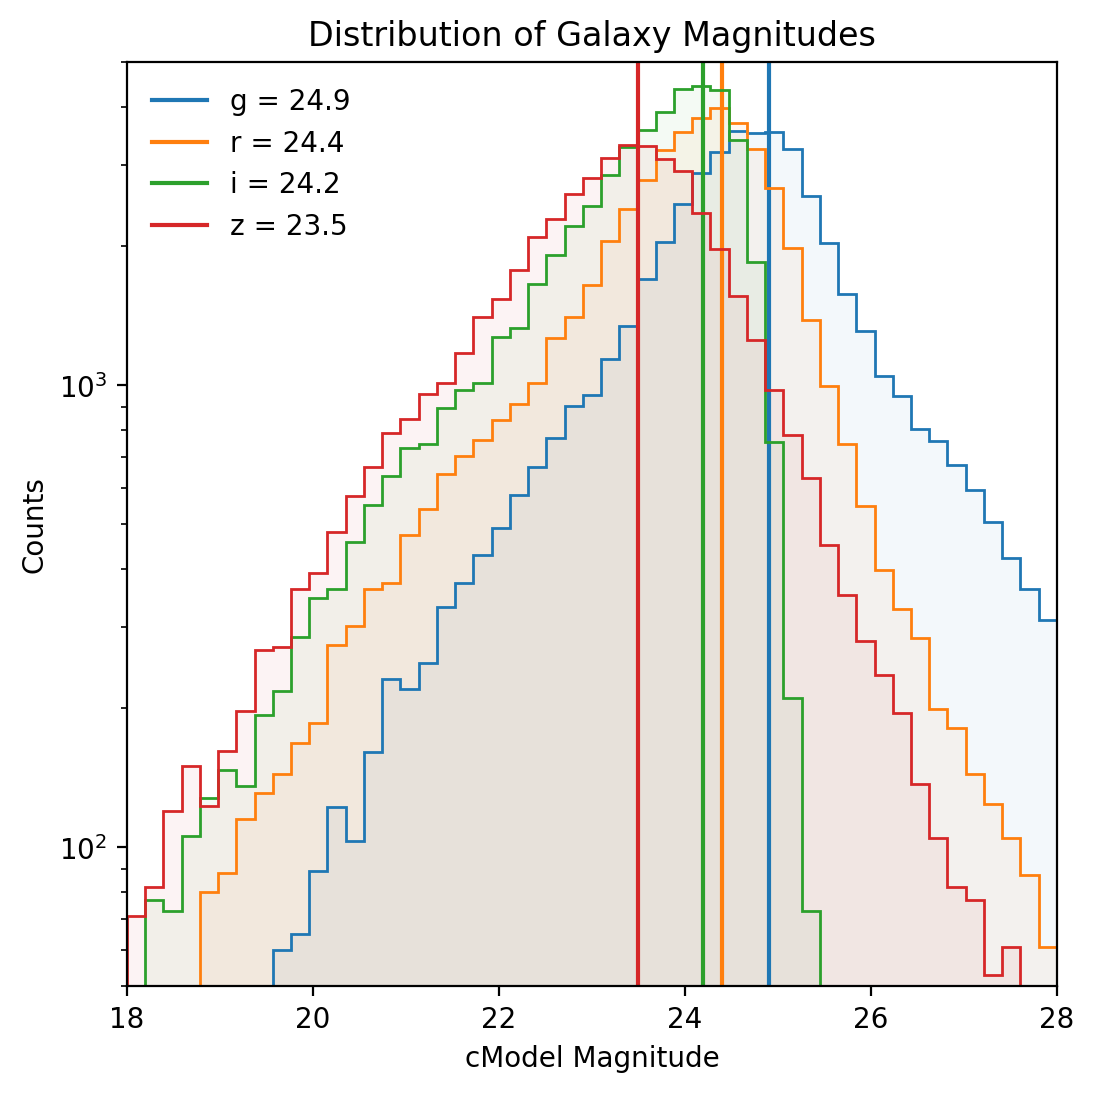

In [55]:
fig, ax = plt.subplots(ncols=1, figsize=(6,6))

near_table = table[np.logical_and(table['sep'] < 0.5, table['refExtendedness']==1)]
cmap = cm.tab10
band_list = 'griz'
# band_lims = [25.3, 24.9, 24.5, 24.0]
band_lims = [24.9, 24.4, 24.2, 23.5]
for i in range(4):
    band = band_list[i]
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), bins=51, histtype='step');
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), color=cmap(i), bins=51, histtype='stepfilled', alpha=0.05);
    ax.axvline(band_lims[i], ls='-', alpha=1, color=cmap(i), label=f'{band} = {band_lims[i]}')
ax.set_xlim(18, 28)
ax.set_ylim(5e1, 5e3)
ax.set_xlabel('cModel Magnitude')
ax.semilogy()
ax.legend(frameon=False, loc='upper left')
ax.set_ylabel("Counts", x=0.05)
ax.set_title("Distribution of Galaxy Magnitudes")
# plt.savefig('./figs/galaxy_dist.png', dpi=450)

## Color Cut

### Red Sequence

We can identify the cluster members by plotting a color magnitude diagram 

575


Text(0.5, 0.01, 'cModel $r$-mag')

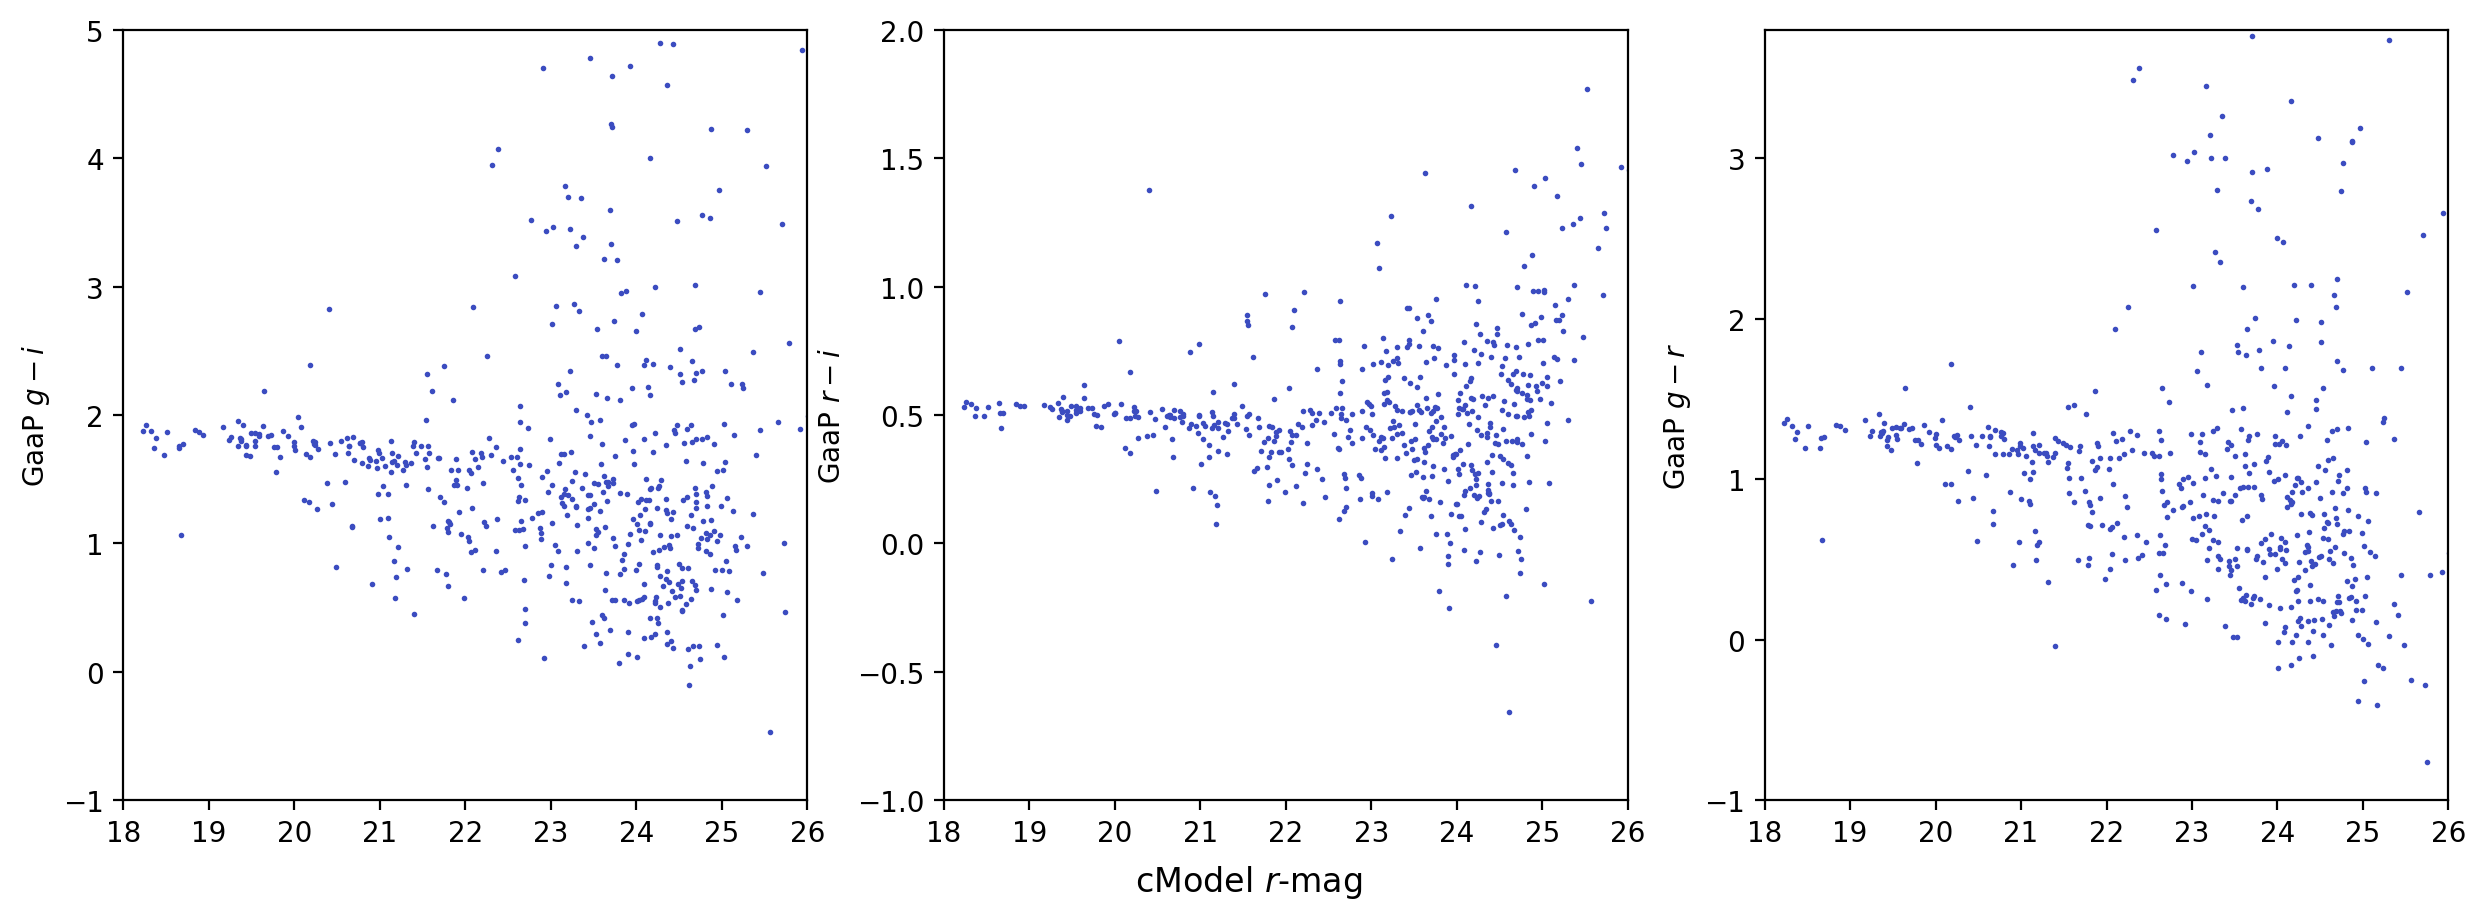

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5)) 

rs_table = table[np.logical_and(table['sep'] < 3/60, table['refExtendedness']==1)]
print(len(rs_table))

color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
cmap = cm.coolwarm
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, color=cmap(0))
    # ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], c=rs_table['sep'], marker='.', s=4)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

fig.supxlabel(r"cModel $r$-mag")

In [57]:
table = apply_redsequence(table)

126 136 122


Text(0.5, 0.01, 'cModel $r$-mag')

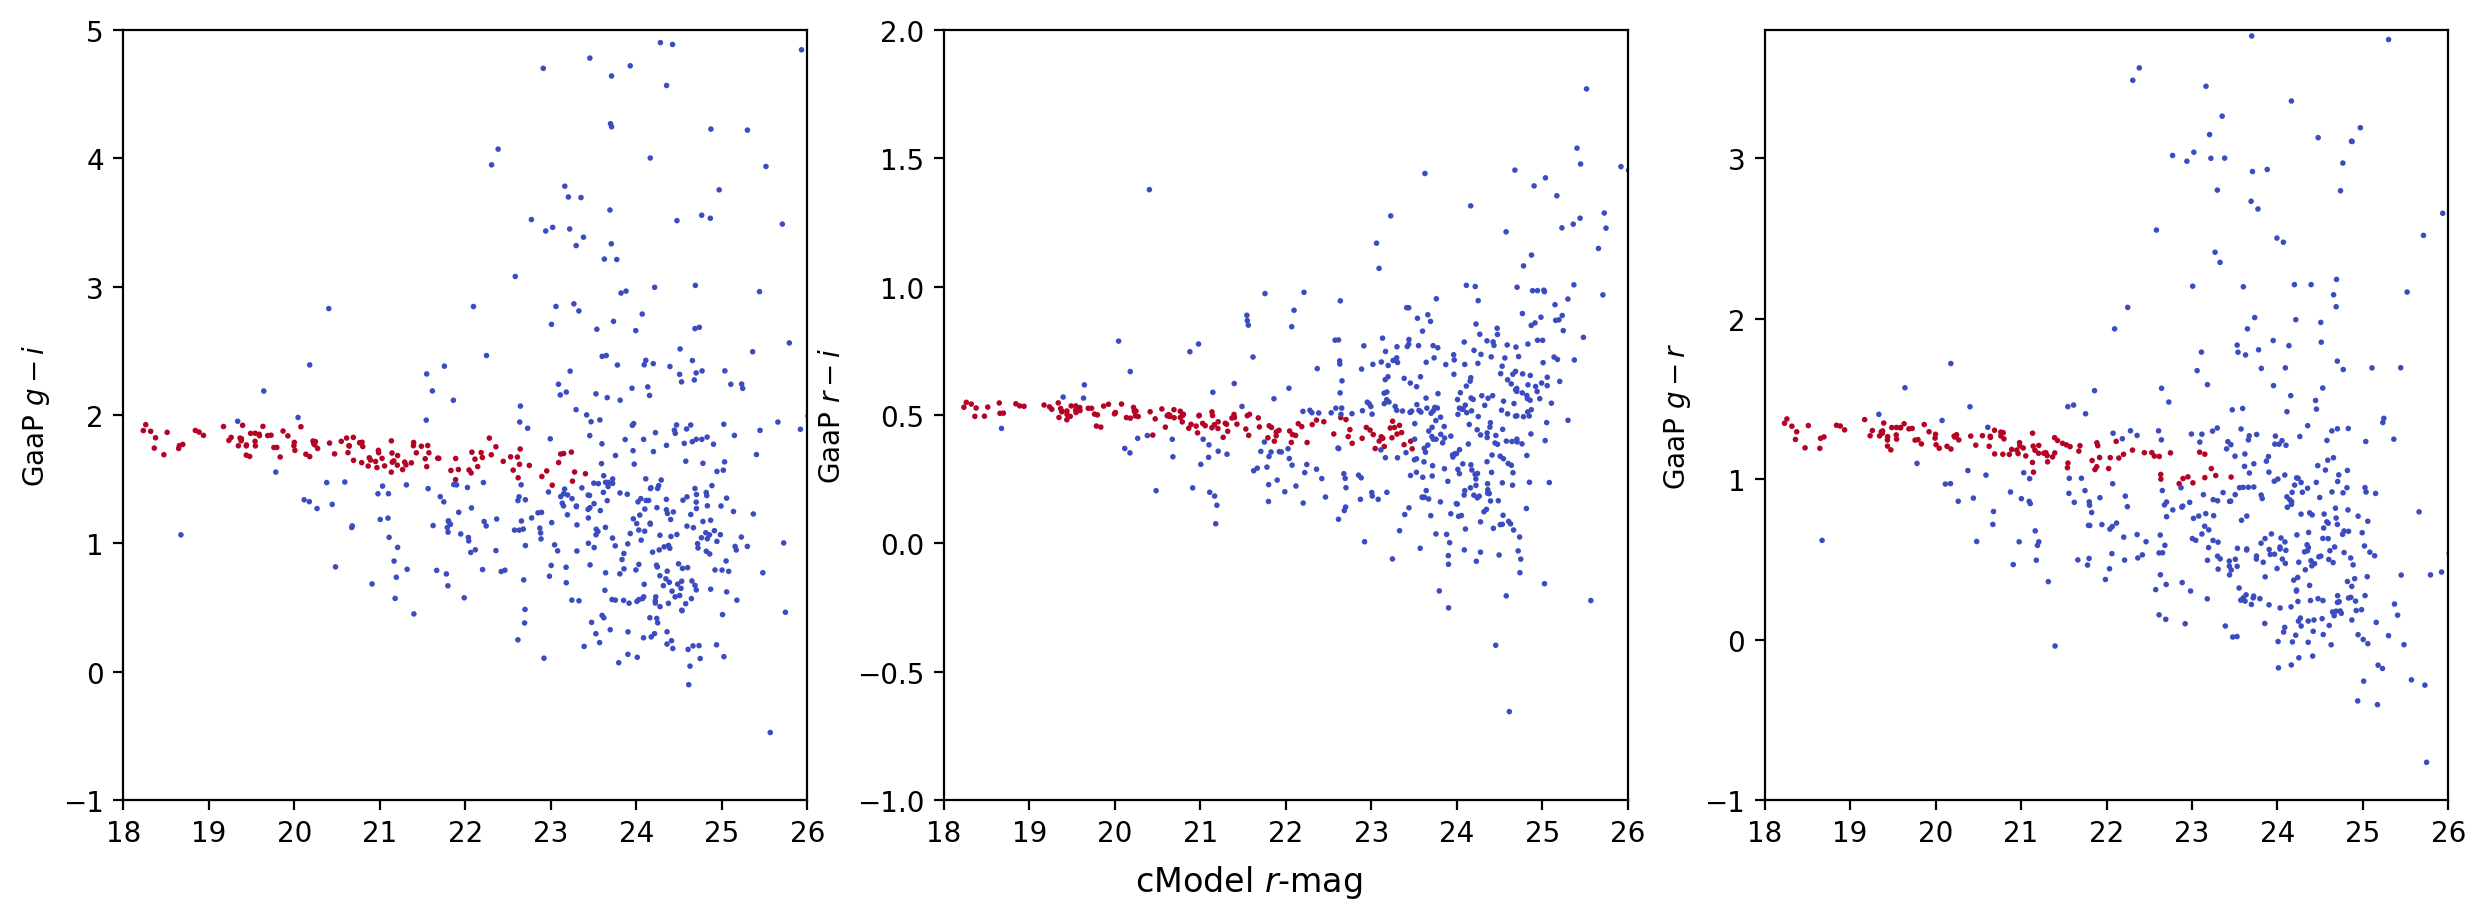

In [58]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 3/60, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, c=rs_table[f'{col}_redseq'], cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

221


Text(0.5, 0.01, 'cModel $r$-mag')

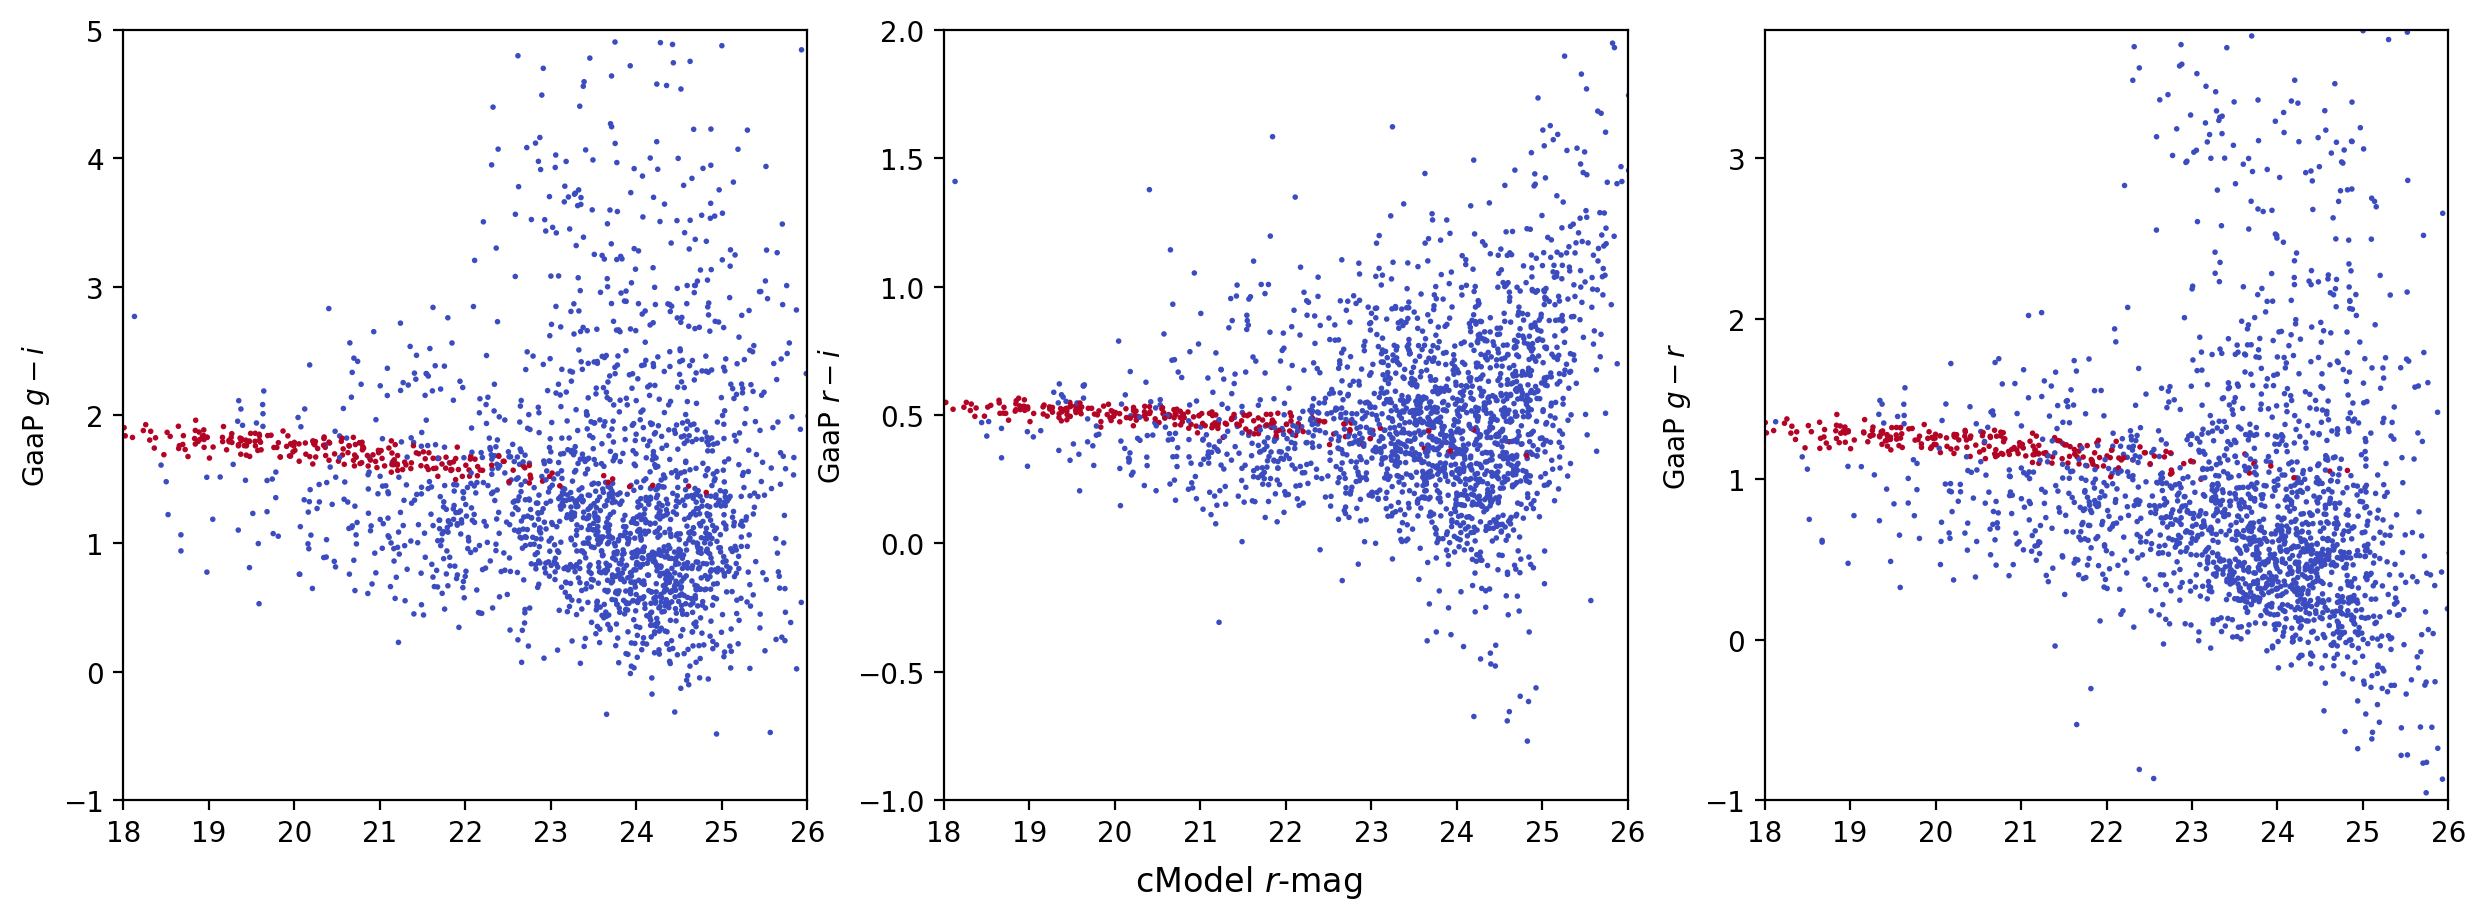

In [59]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(table['sep'] < 0.1, table['refExtendedness']==1)]
print(np.sum(rs_table['all_redseq']))
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, c=rs_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

In [60]:
Nobj = len(table)
Nrs = np.sum(table['all_redseq'])
print(Nrs, Nobj-Nrs)

1144 57532


### Write Tables

In [61]:
# Apply cuts
cut_types = ['all', 'ri', 'gr', 'gi']
wl_filt = get_wlfilt(table, mag_lim=23.76)
for ct in cut_types:
    filt = np.logical_and(wl_filt,  ~(table[f'{ct}_redseq']))
    print(f"After {ct} cuts: {np.sum(filt)}")
    source_table = table[filt]
    source_table.meta = {}
    source_table.write(f'{outdir}/abell360_POSTCUTS_{ct}_DP1_new.fits', format="fits", overwrite=True)

After WL cuts: 20693
After all cuts: 20153
After ri cuts: 18353
After gr cuts: 18843
After gi cuts: 18926


In [62]:
weaklen_table = Table.read(f'{outdir}/abell360_POSTCUTS_all_DP1_new.fits', format='fits')

## Photo-z Cuts

Another way for us to obtain the source sample is by removing objects that have $z \leq 0.22$ which we can do using photometric redshift estimates.
Here we load in both the point estimates and the $P(z)$ distributions for each object.

In [67]:
# # Get point estimates for the entire field (169034 objects)
# pz_ests = pd.read_parquet(pz_sv38_point)
# pz_ests = Table.from_pandas(pz_ests)

In [303]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [92]:
# We could load this in via butler we did save this earlier :)
# This is the cleaned catalog that removed entries if any of the measurement algorithms failed.
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_new.fits', format="fits")
dp1_catalog, _ = load_pz_photomdata(ddir='/global/cfs/cdirs/lsst/groups/PZ/DP1/data/dp1_v29.0.0/', suffix='parquet')
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

/pscratch/sd/p/pecom/envs/anacal_mpi/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pscratch/sd/p/pecom/envs/anacal_mpi/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [305]:
pz_table = join(dp1_catalog, pz_ests, keys='objectId')

In [306]:
# The P(z) PDFs are stored in a qp file which we can access via the get_pdfs function
# This contains the PDFs for all objects in the field which would be too much data to
# load in this notebook. We only want the PDFs for the objects that have passed our
# basic quality cuts.

clean_pz_ids = pz_table['objectId']
all_pz_ids = pz_ests['objectId']
big_pz_filt = np.isin(all_pz_ids, clean_pz_ids)
# big_pz_filt = [k in clean_pz_ids for k in pz_ests['objectId']]


In [307]:
xs = np.linspace(0, 3, 301)

### Entire Sample $N(z)$

In [308]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 29364
On tpz we have 29538
On fzboost we have 27654
On knn we have 33273


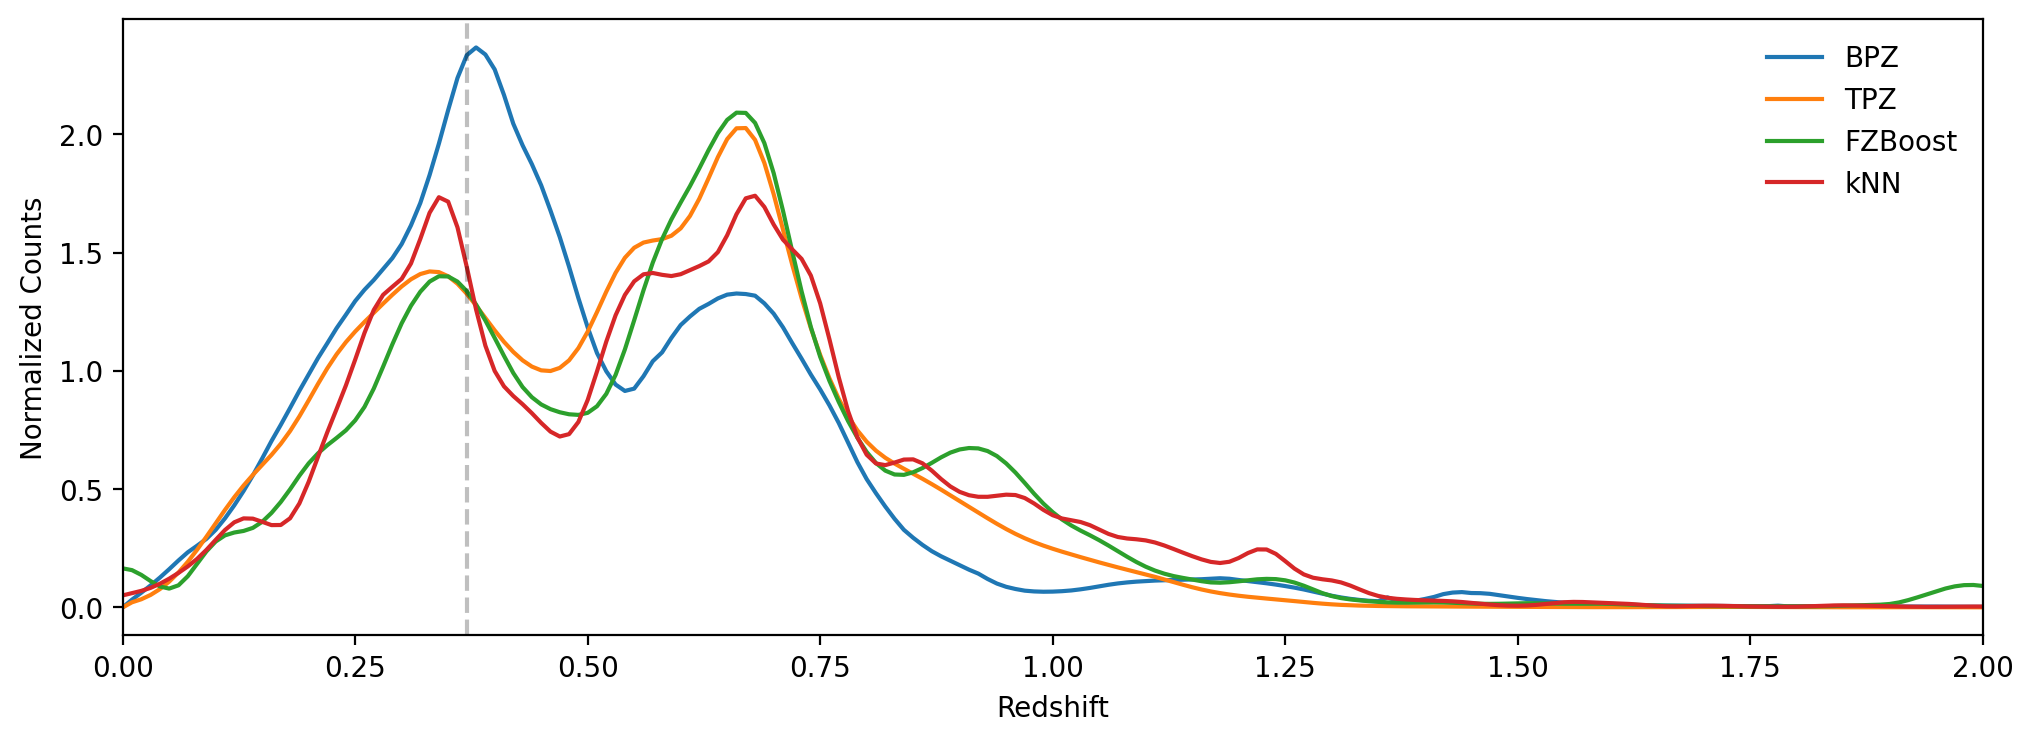

In [185]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

### Write Tables

Save the photo-z subsets

In [211]:
# Apply cuts
pz_algs = ['knn', 'tpz', 'cmnn', 'gpz', 'bpz', 'dnf', 'fzboost', 'lephare']
pz_cutoff = 0.37
# pz_cutoff2 = 0.65
pz_wlfilt = get_wlfilt(pz_table)

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'

    filt = np.logical_and(pz_wlfilt, pz_table[f'{alg}_z_{central}'] > pz_cutoff)
    if not (alg=='gpz'):
        filt &= pz_table[f'{alg}_diff'] < 0.25

    print(f"After cuts: {np.sum(filt)}")
    source_table = pz_table[filt]
    source_table.write(f'cluster_data/technote/abell360_POSTCUTS_{alg}0.37_DP1.fits', format="fits", overwrite=True)

After WL cuts: 43311
After cuts: 15310
After cuts: 15779
After cuts: 3514
After cuts: 41228
After cuts: 14050
After cuts: 19676
After cuts: 15437
After cuts: 4796


Save subsets for the shear-ratio plot

In [197]:
# Apply cuts
pz_algs = ['knn', 'tpz', 'cmnn', 'gpz', 'bpz', 'dnf', 'fzboost', 'lephare']
pz_cutoff1 = 0.37
pz_cutoff2 = 0.65

pz_wlfilt = get_wlfilt(pz_table)

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'

    filt = np.logical_and(pz_wlfilt, pz_table[f'{alg}_z_{central}'] > pz_cutoff)
    filt &= pz_table[f'{alg}_z_{central}'] > pz_cutoff2 # Change this from < to > when doing bin1 or bin2
    if not (alg=='gpz'):
        filt &= pz_table[f'{alg}_diff'] < 0.25

    print(f"After cuts: {np.sum(filt)}")
    source_table = pz_table[filt]
    source_table.write(f'cluster_data/technote/shear-ratio_{alg}bin2_DP1.fits', format="fits", overwrite=True)

After WL cuts: 43311
After cuts: 8567
After cuts: 7244
After cuts: 2214
After cuts: 31415
After cuts: 5061
After cuts: 8991
After cuts: 8259
After cuts: 1261


In [110]:
# color_cut_nz = Table.read('./cluster_data/technote/abell360_POSTCUTS_all_DP1_new.fits')

In [329]:
pzo = pz_ests['objectId']
clean_pz_ids = color_cut_nz['objectId']
big_pz_filt = [k in clean_pz_ids for k in pzo]

xs = np.linspace(0, 3, 301)

In [330]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 20.25)#, pz_table['all_redseq']==True)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 17319
On tpz we have 17319
On fzboost we have 17319
On knn we have 17319


In [331]:
quality_pdfs = np.array(quality_pdfs)

In [303]:
quality_pdfs.shape

(4, 301)

In [376]:
np.save('cluster_data/technote/nz/colorcuts_nz_noquality.npy', quality_pdfs)

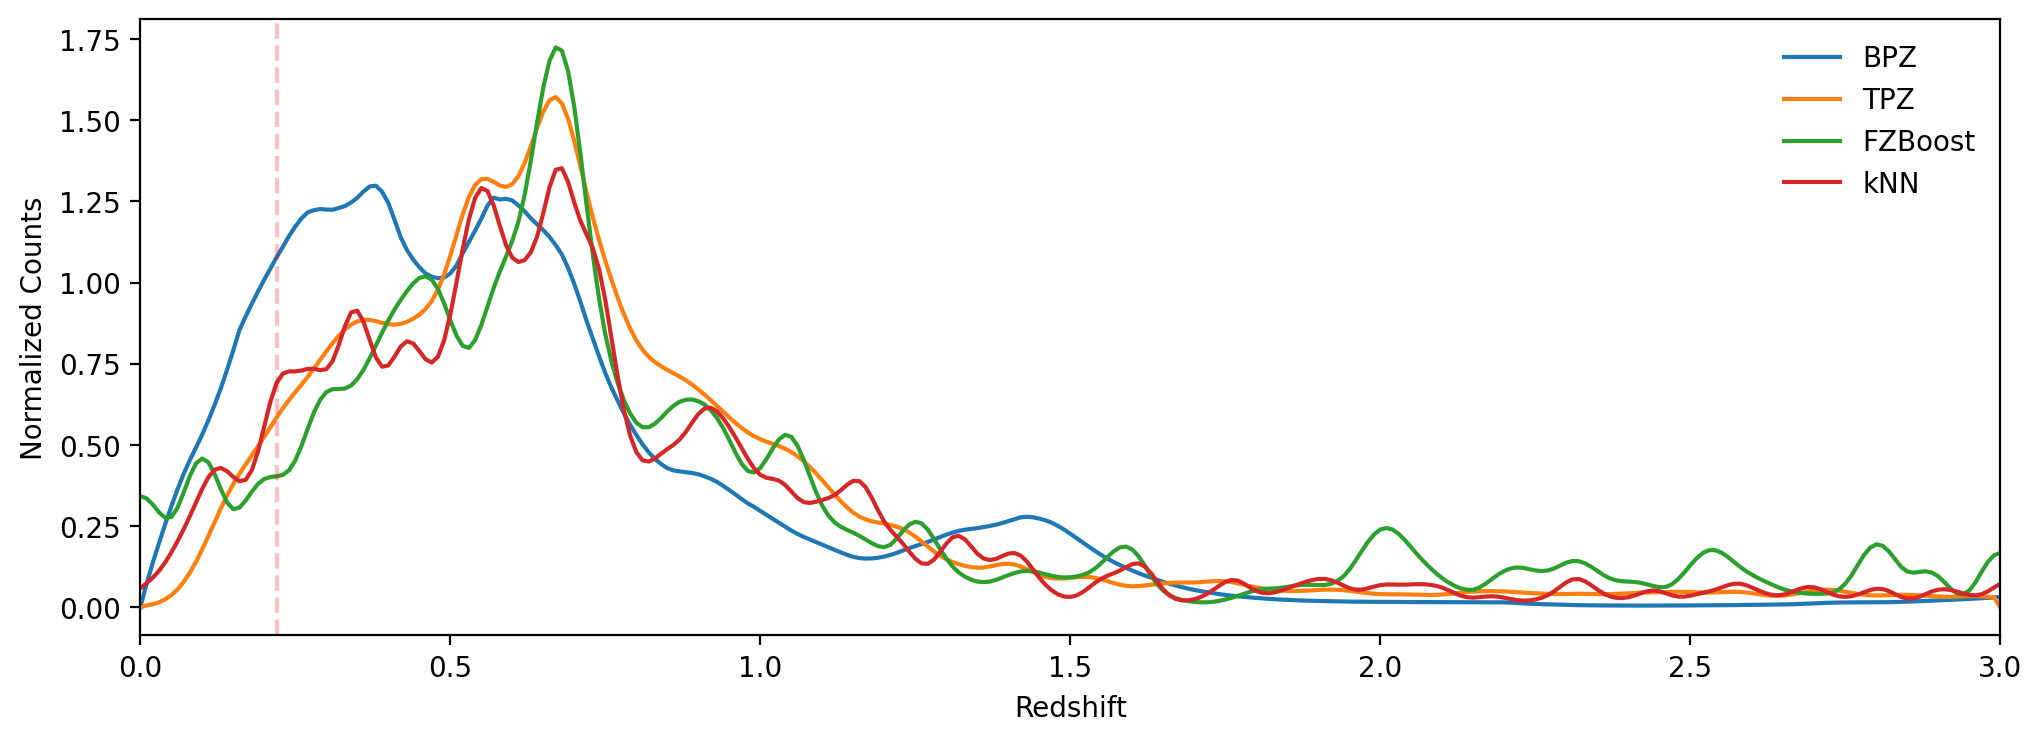

In [333]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 3)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

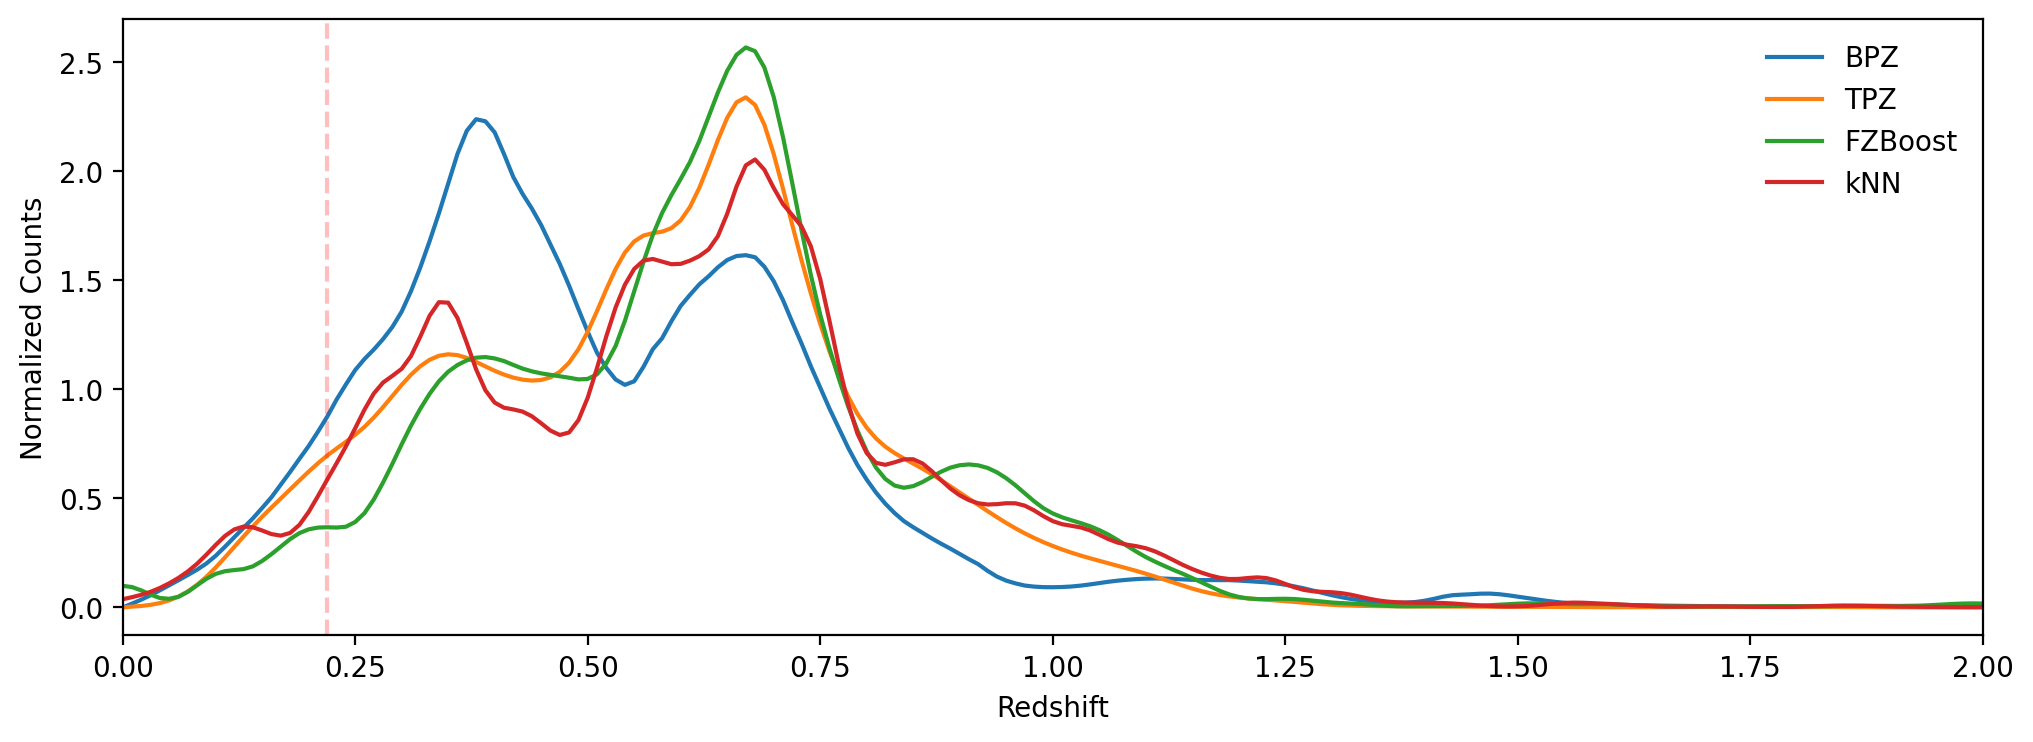

In [292]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

## Color-Color Cuts

In [152]:
match_cc = Table.read('/home/a/adari/u/clusters/data/match_desi.fits')

In [153]:
# match_cc['gi'] = match_cc['g_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# match_cc['ri'] = match_cc['r_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# match_cc['gr'] = match_cc['g_gaap1p0Mag'] - match_cc['r_gaap1p0Mag']

In [154]:
bands = list('griz')
for b in bands:
    match_cc.rename_column(f'{b}_cModelMag', f'{b}_cModel_mag')
    match_cc.rename_column(f'{b}_gaap1p0Mag', f'{b}_gaap_mag')

In [155]:
match_cc = apply_redsequence(match_cc)

In [158]:
clean_filt = preclean_filt(preclean_table)
print(len(preclean_table) - np.sum(clean_filt))
clean_table = preclean_table[clean_filt]

116707


In [178]:
clean_table = apply_redsequence(clean_table, mag_lim=28)

In [351]:
cmap = cubehelix_colormap(
   start=0,
   rot=-0.1,
   gamma=1,
   hue=5,
   light=0.85,
   dark=0.15,
   name="test",
)
cmap_r = cmap.reversed()

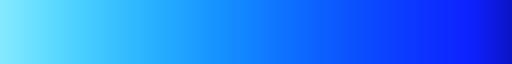

In [352]:
cmap_r

In [405]:
imag_cut = wl_table[wl_table['i_cModel_mag'] < 23.76]
imag_cut = apply_redsequence(imag_cut)

Text(0, 0.5, 'r-i')

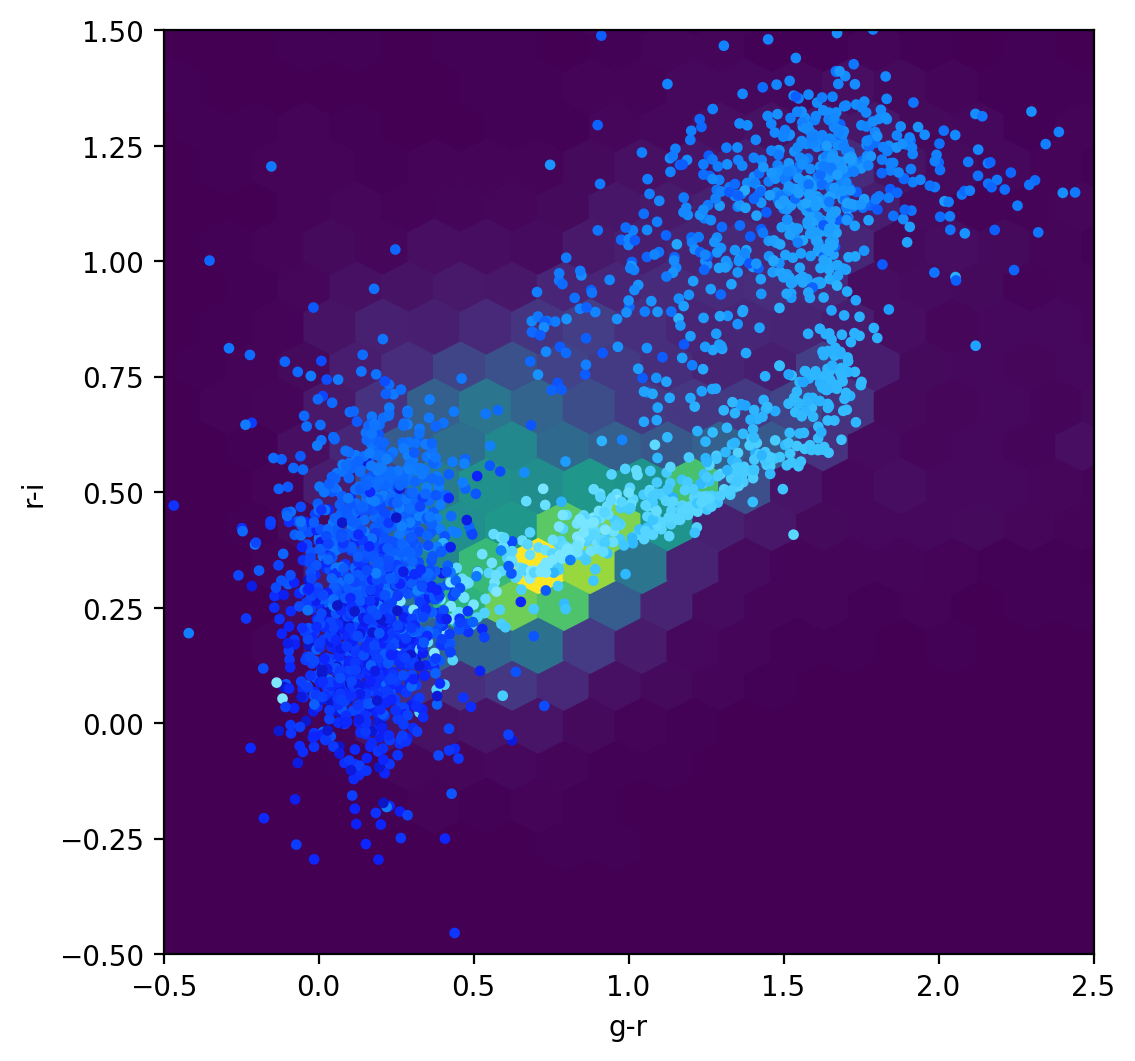

In [410]:
fig, ax = plt.subplots(1, figsize=(6,6))

# cmap = cm.coolwarm
ax.hexbin(imag_cut['gr'] ,imag_cut['ri'])
ax.scatter(match_cc['gr'], match_cc['ri'], s=8, c=match_cc['desi_z'], cmap=cmap_r)


ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel("g-r")
ax.set_ylabel("r-i")

Text(0, 0.5, 'r-i')

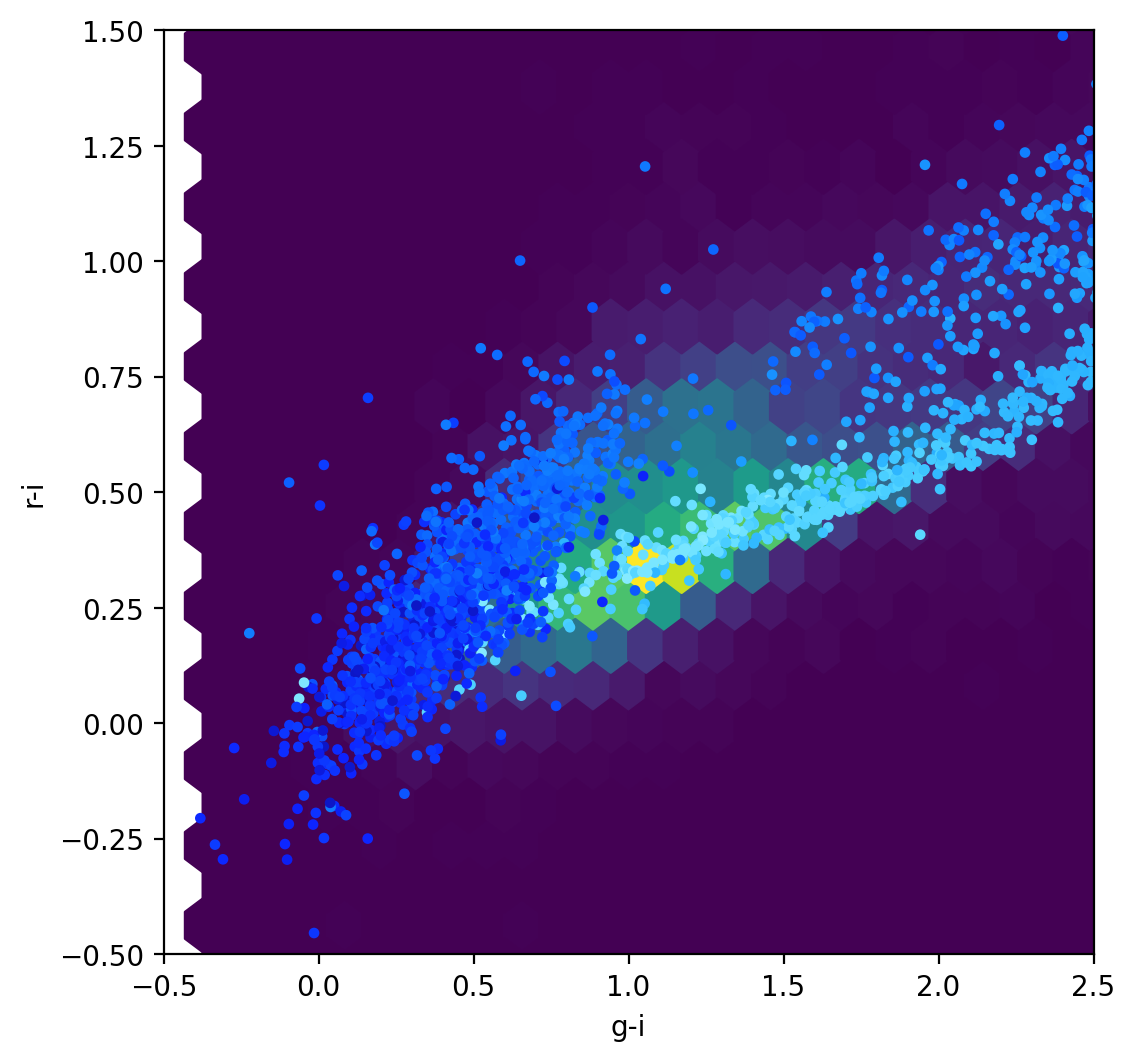

In [411]:
fig, ax = plt.subplots(1, figsize=(6,6))

# cmap = cm.coolwarm
ax.hexbin(imag_cut['gi'] ,imag_cut['ri'])
ax.scatter(match_cc['gi'], match_cc['ri'], s=8, c=match_cc['desi_z'], cmap=cmap_r)


ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel("g-i")
ax.set_ylabel("r-i")

## Color-Cuts N(z)

### SV 38-7 $N(z)$

In [133]:
# Get point estimates for the entire field (169034 objects)
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)
pz_ests = Table.from_pandas(pz_ests)

In [134]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [135]:
# We could load this in via butler we did save this earlier :)
# This is the cleaned catalog that removed entries if any of the measurement algorithms failed.
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_new.fits', format="fits")
dp1_catalog = load_pz_photomdata()
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [136]:
pz_table = join(dp1_catalog, pz_ests, keys='objectId')

In [137]:
pz_table = apply_redsequence(pz_table)

In [138]:
pz_wlfilt = get_wlfilt(pz_table)
wl_pztable = pz_table[np.logical_and(pz_wlfilt, ~pz_table['all_redseq'])]
print(len(wl_pztable))

After WL cuts: 17828
17308


In [139]:
# True for objects that SHOULD be in the weak lensing catalog

wl_pz_ids = wl_pztable['objectId']
all_pz_ids = pz_ests['objectId']
# wl_pz_filt = np.array([k in wl_pz_ids for k in pz_ests['objectId']])
wl_pz_filt = np.isin(all_pz_ids, wl_pz_ids)

In [140]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
wl_pdfs = []

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'
    new_filt = np.logical_and.reduce((wl_pz_filt, pz_ests[f'{alg}_z_{central}'] > pz_cutoff,
                                      pz_ests[f'{alg}_diff'] < 0.25))
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)
    wl_pdfs.append(pdf)

On bpz we have 5488
On tpz we have 5938
On fzboost we have 6173
On knn we have 6156


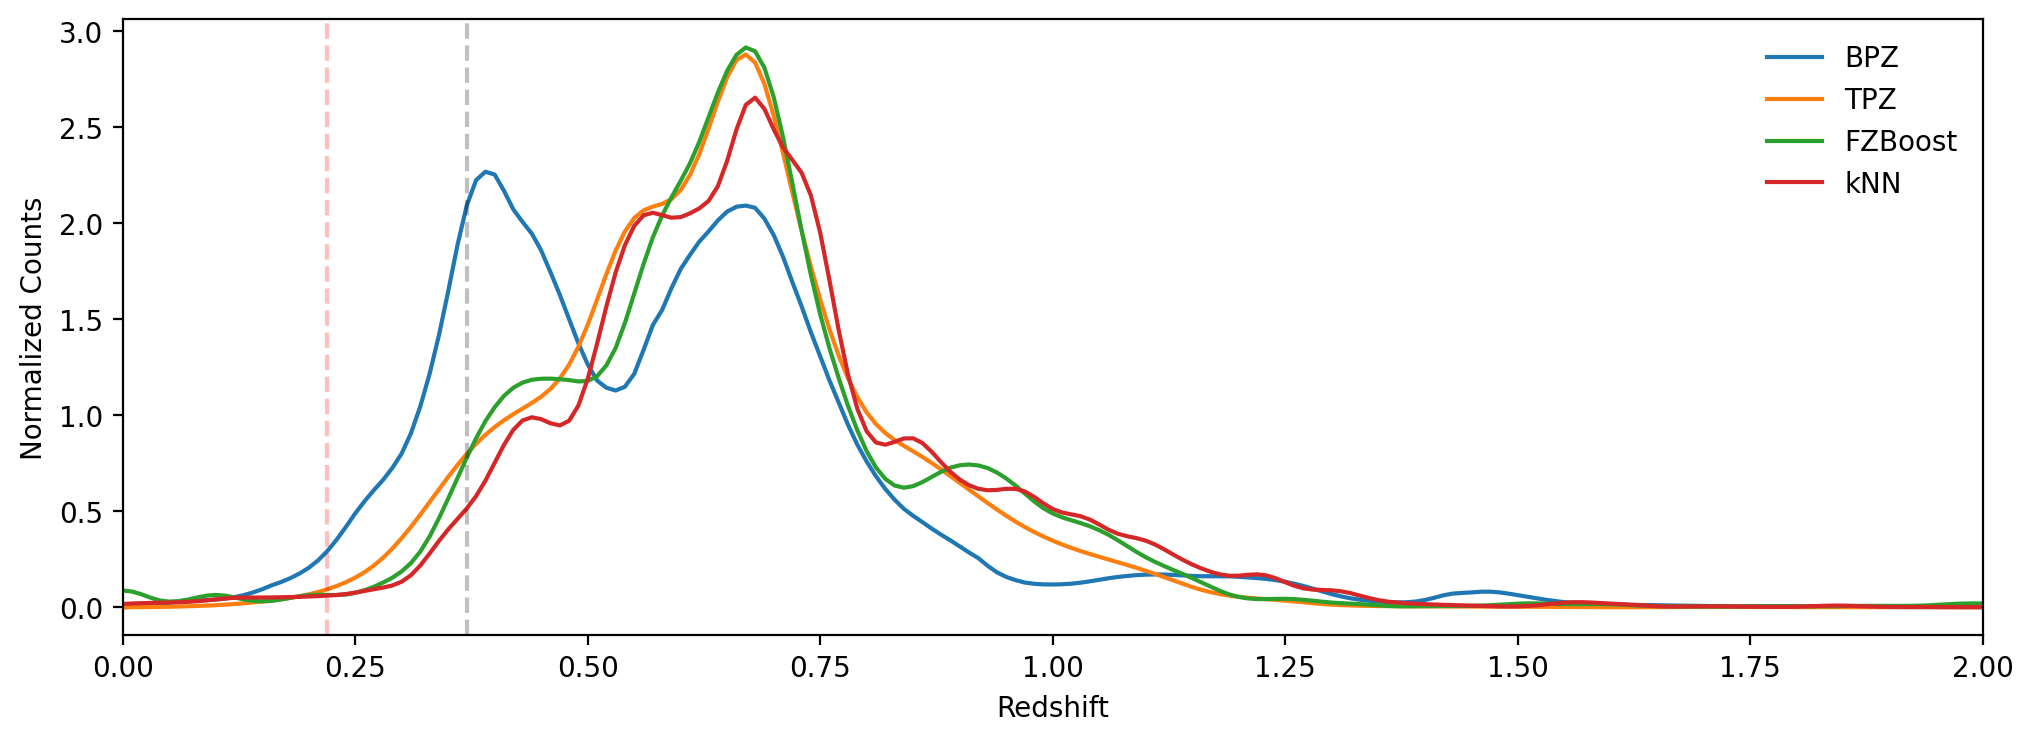

In [141]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, wl_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

#### Red Sequence Redshifts and N(z)s

In [256]:
rs_ids = pz_table['objectId'][pz_table['all_redseq']]

In [257]:
pzo = pz_ests['objectId']

rs_ids = pz_table['objectId'][pz_table['all_redseq']]
rs_pz_filt = np.isin(all_pz_ids,rs_ids)

xs = np.linspace(0, 3, 301)

In [258]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(rs_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 1745
On tpz we have 1667
On fzboost we have 1357
On knn we have 1383


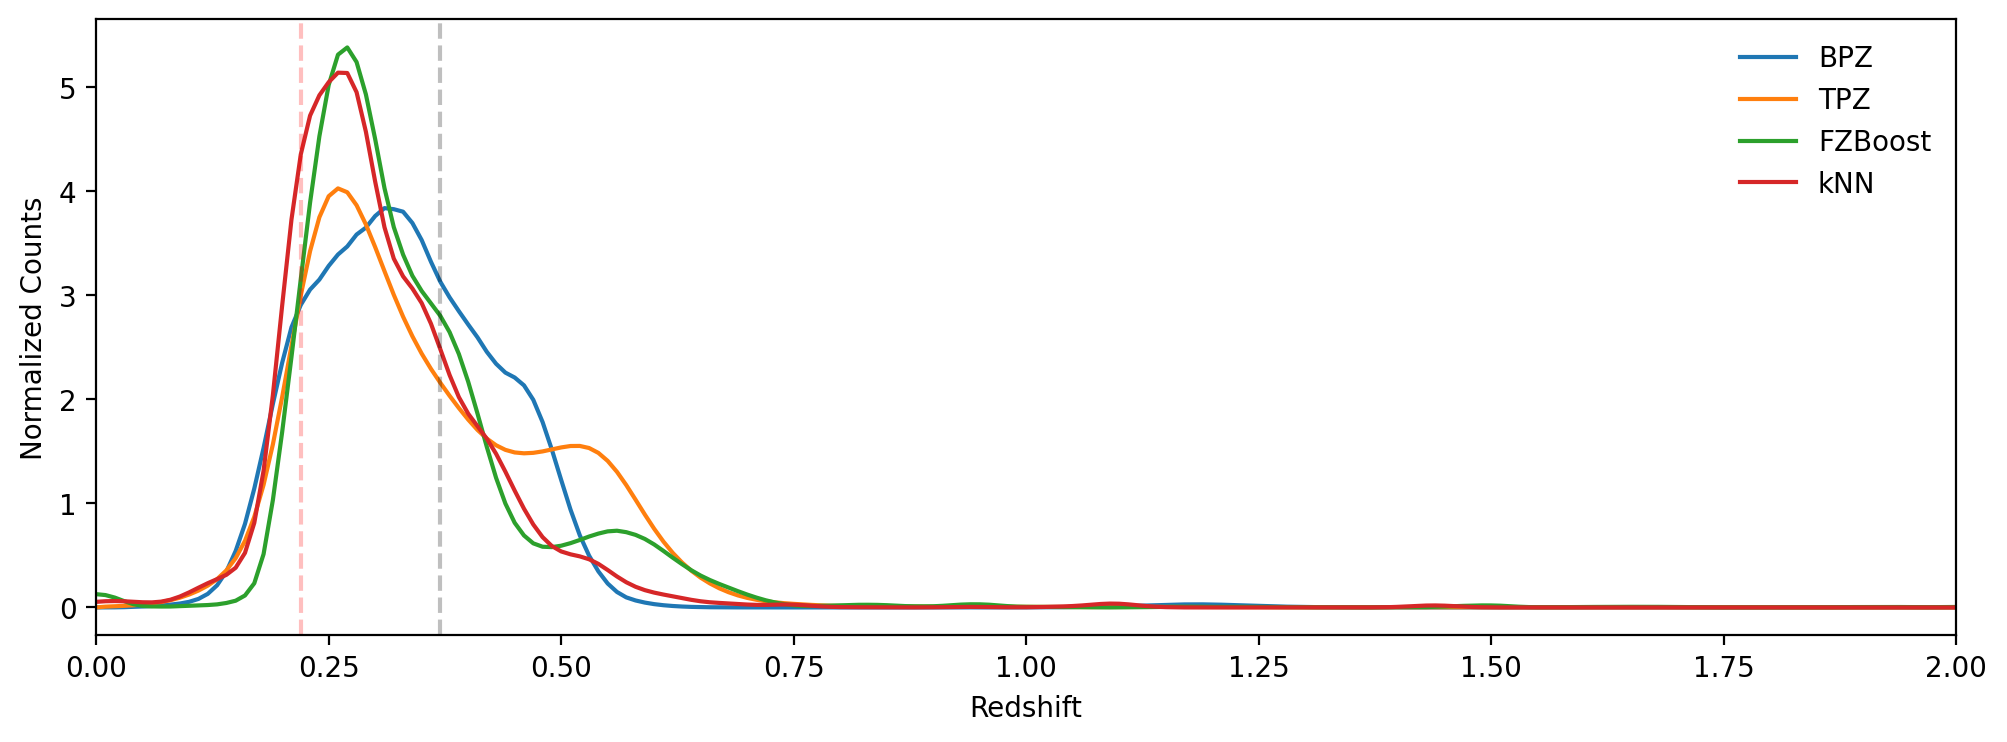

In [260]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

#### DESI Matched


In [142]:
match_cc = Table.read('/home/a/adari/u/clusters/data/match_desi.fits')

In [143]:
# match_cc['gi'] = match_cc['g_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# match_cc['ri'] = match_cc['r_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
# match_cc['gr'] = match_cc['g_gaap1p0Mag'] - match_cc['r_gaap1p0Mag']

In [144]:
bands = list('griz')
for b in bands:
    match_cc.rename_column(f'{b}_cModelMag', f'{b}_cModel_mag')
    match_cc.rename_column(f'{b}_gaap1p0Mag', f'{b}_gaap_mag')

In [145]:
match_cc = apply_redsequence(match_cc)

In [146]:
redseq_match = match_cc[match_cc['all_redseq']]

In [147]:
pzo = pz_ests['objectId']

desi_rs_ids = redseq_match['objectId']
rs_desi_filt = np.isin(pzo,desi_rs_ids)

xs = np.linspace(0, 3, 301)

In [148]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(rs_desi_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 62
On tpz we have 60
On fzboost we have 60
On knn we have 55


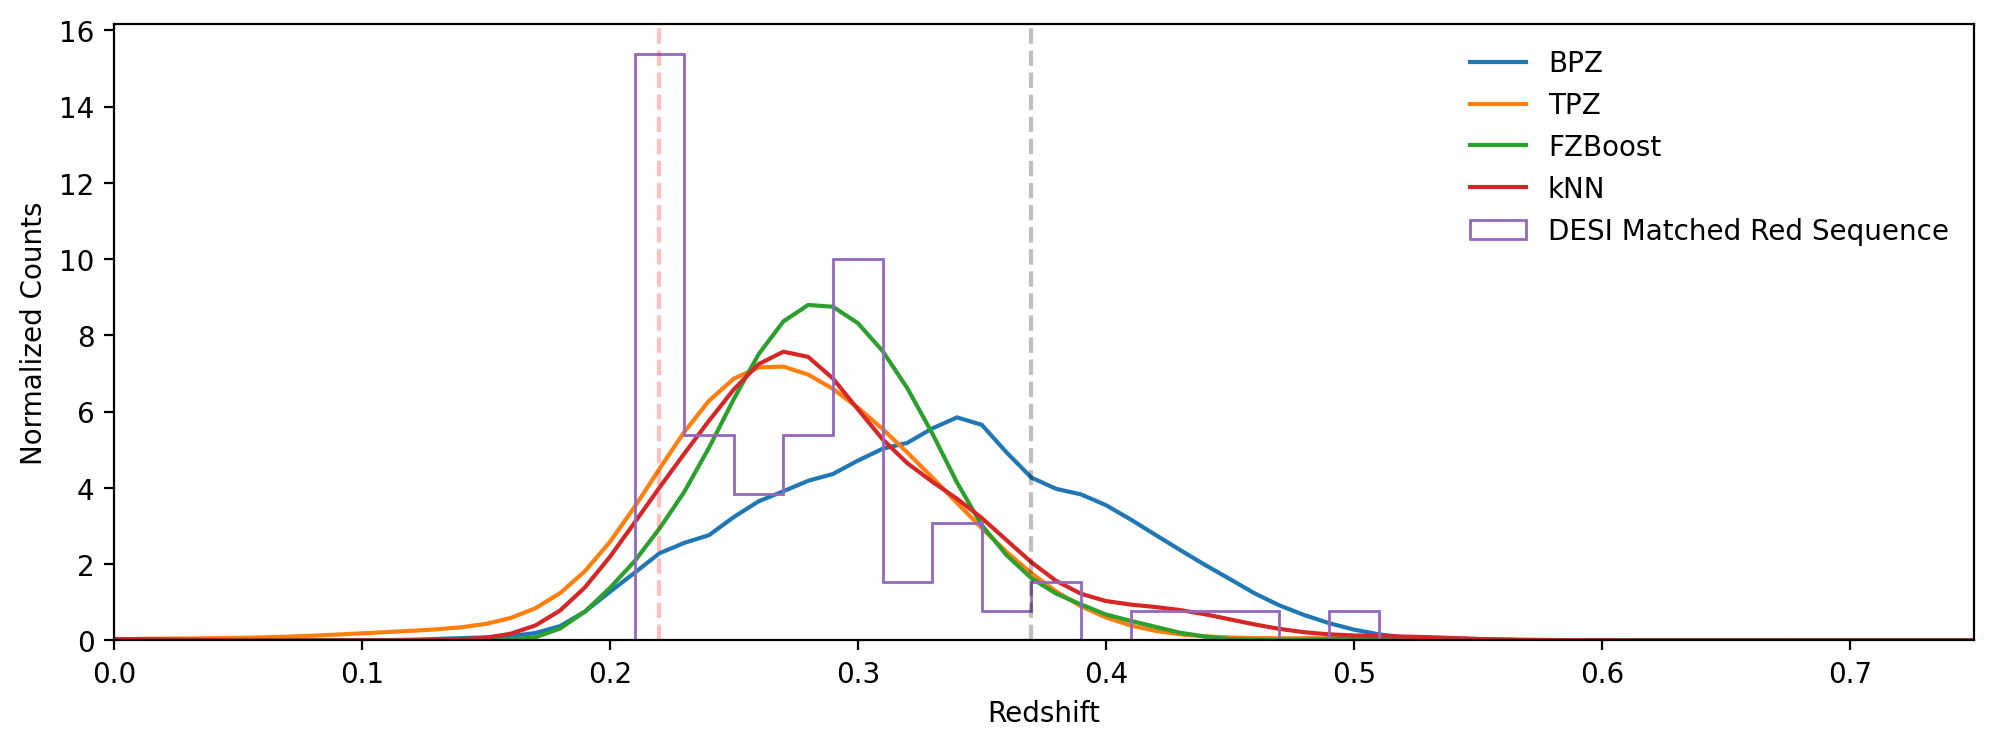

In [149]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25, label="DESI Matched Red Sequence", density=True)
ax.legend(frameon=False)
ax.set_xlim(0, .75)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

Text(0, 0.5, 'Counts')

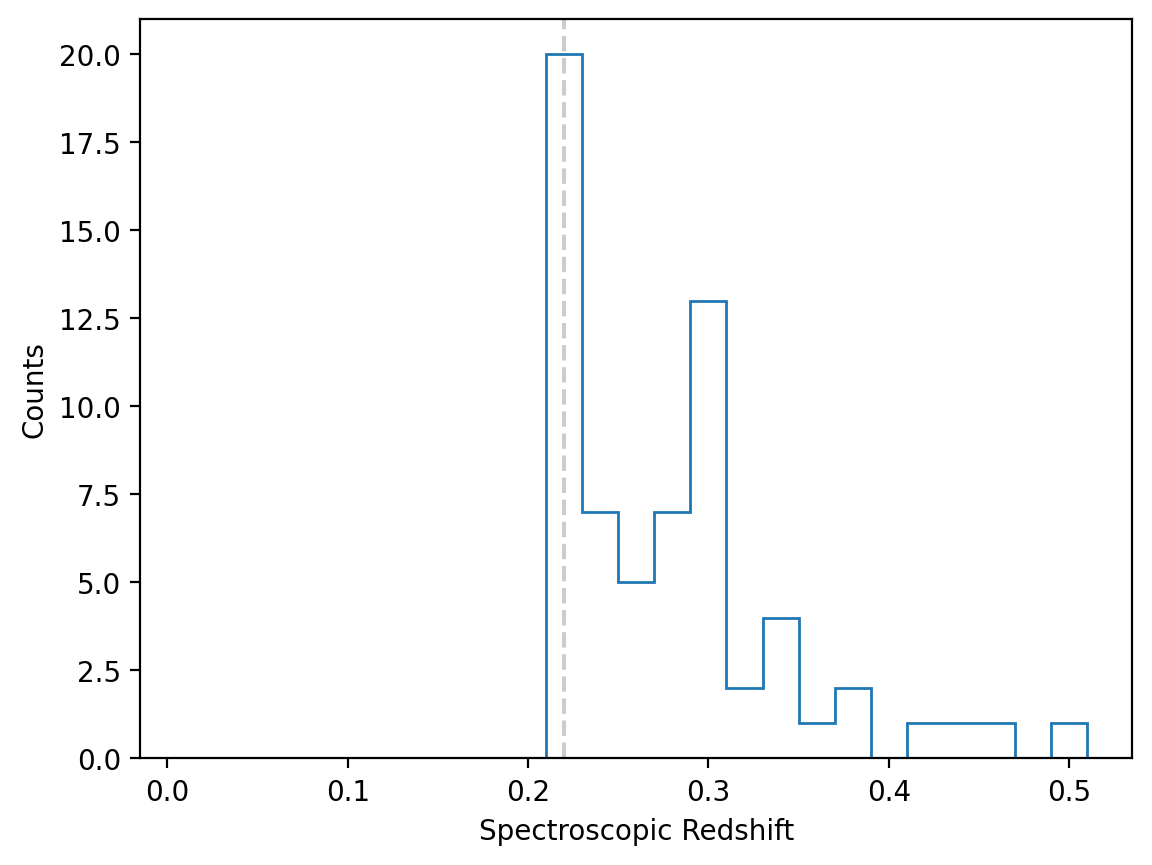

In [150]:
plt.axvline(0.22, ls='--', color='k', alpha=0.2)
plt.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25, label="Matched Red Sequence")
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Counts")

### ECDFS N(z) from color cuts

#### Load ECDFS Photo-Z Data

In [519]:
bands = list('ugrizy')
ecdfs_cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
ecdfs_gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]

ecdfs_object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + ecdfs_cmodel_bands + ecdfs_gaap_bands

ecdfs_tracts = [5063, 4849, 4848]


In [520]:
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)
pz_ests = Table.from_pandas(pz_ests)

In [521]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [522]:
dp1_catalog, preclean_ecdfs = load_pz_photomdata(tracts=ecdfs_tracts, columns=ecdfs_object_req_cols)
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


[]

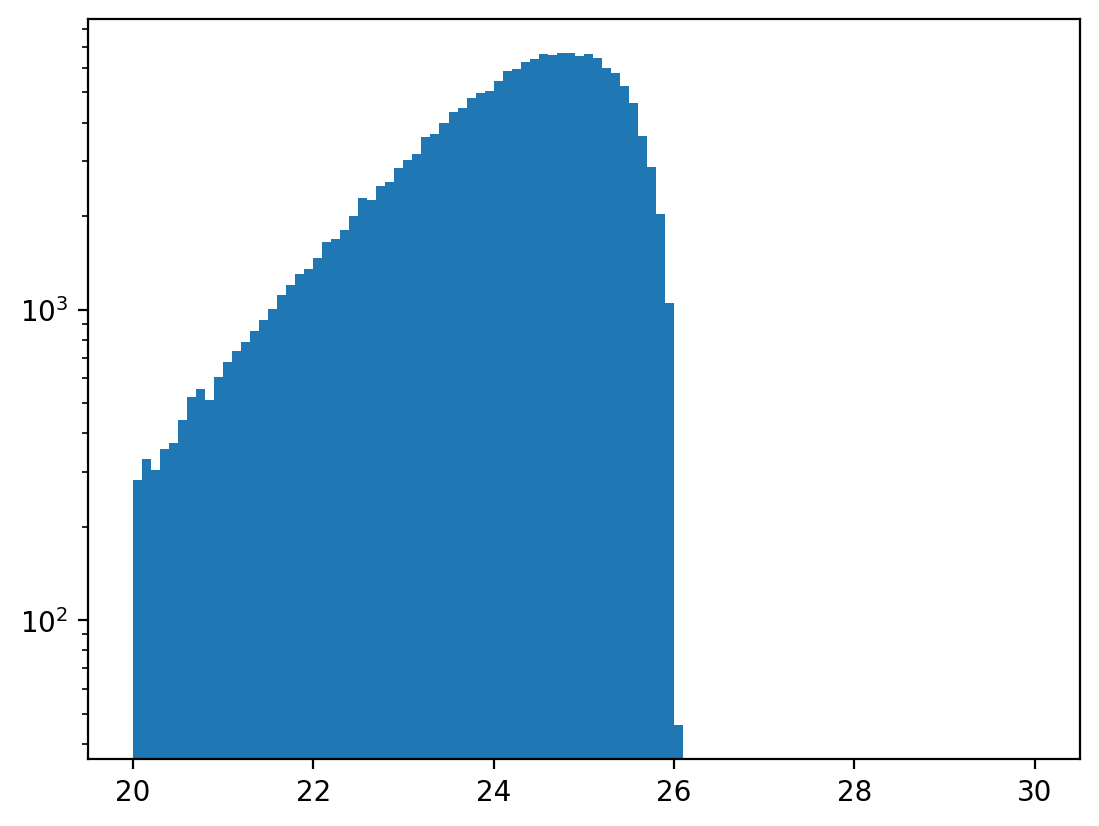

In [532]:
plt.hist(preclean_ecdfs['i_cModel_mag'], range=(20, 30), bins=100);
plt.semilogy()

In [482]:
ecdfs_table = join(dp1_catalog, pz_ests, keys='objectId')
ecdfs_table.add_index('objectId')
ecdfs_table = Table.filled(ecdfs_table, fill_value=np.nan)

#### Apply Quality + RS Cuts

In [483]:
ecdfs_table = apply_redsequence(ecdfs_table)
ecdfs_wl = get_wlfilt(ecdfs_table, apply_sep=False)
ecdfs_wl_table = ecdfs_table[ecdfs_wl]

After WL cuts: 48490


Text(0.5, 0.01, 'cModel $r$-mag')

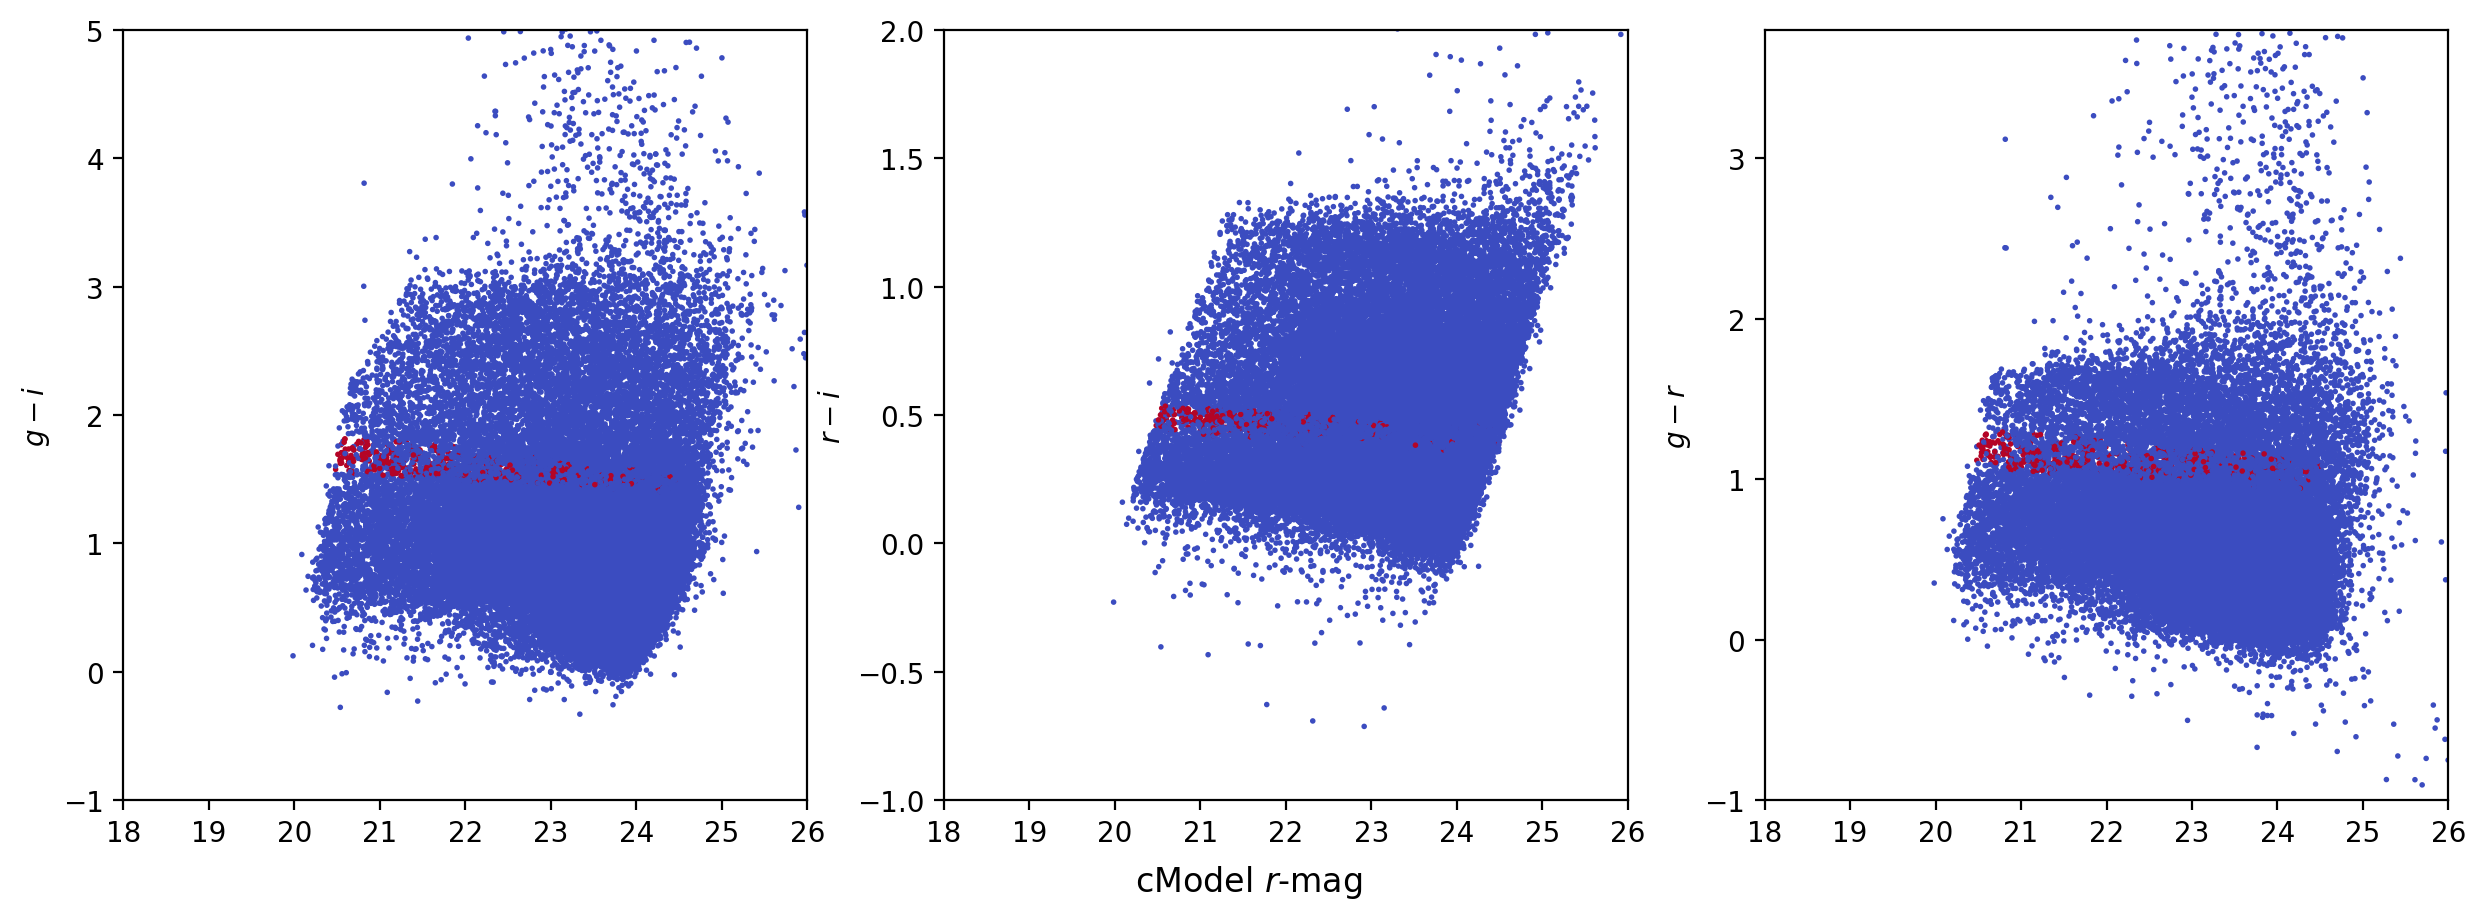

In [484]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(ecdfs_wl_table['r_cModel_mag'], ecdfs_wl_table[col], marker='.', s=4,
                  c=ecdfs_wl_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(col_name[i])
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

#### $N(z)$

In [485]:
cut_gal_pz = ecdfs_wl_table[~ecdfs_wl_table['all_redseq']]

In [486]:
pzo = pz_ests['objectId']
ecdfs_pzo = cut_gal_pz['objectId']

ecdfs_nz_filt = np.isin(pzo, ecdfs_pzo)

In [487]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
ecdfs_nz_pdfs = np.zeros((len(pz_algs), 201))

for i,alg in enumerate(pz_algs):
    new_filt = np.logical_and(ecdfs_nz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, xs = get_pdfs_ecdfs(alg, new_filt)
    c = gc.collect()
    ecdfs_nz_pdfs[i,:] = pdf

On bpz we have 14670
On tpz we have 12872
On fzboost we have 27732
On knn we have 23010


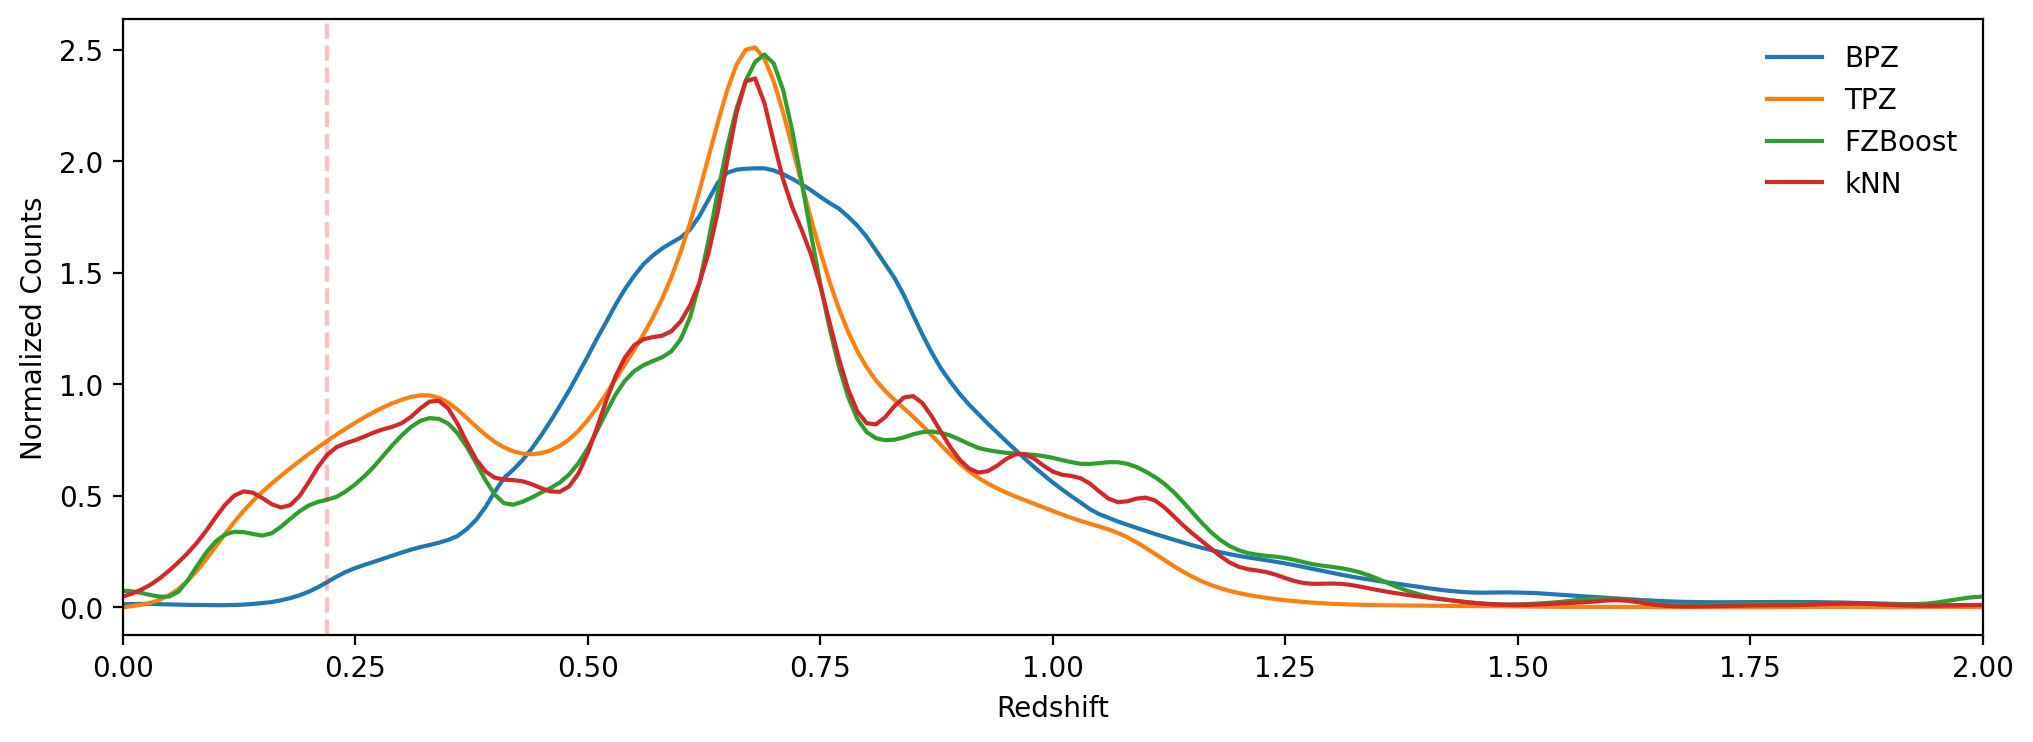

In [54]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, ecdfs_nz_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

## Profile Comparison

In [179]:
with open(f'./cluster_data/technote/profile_all_y3', 'rb') as f:
    profile = pickle.load(f)

In [382]:
cc_types = ['all', 'gi', 'ri', 'gr']
profiles = []

for cc in cc_types:
    with open(f'./cluster_data/technote/profile_{cc}_y3', 'rb') as f:
        profile = pickle.load(f)
        profiles.append(profile.profile)

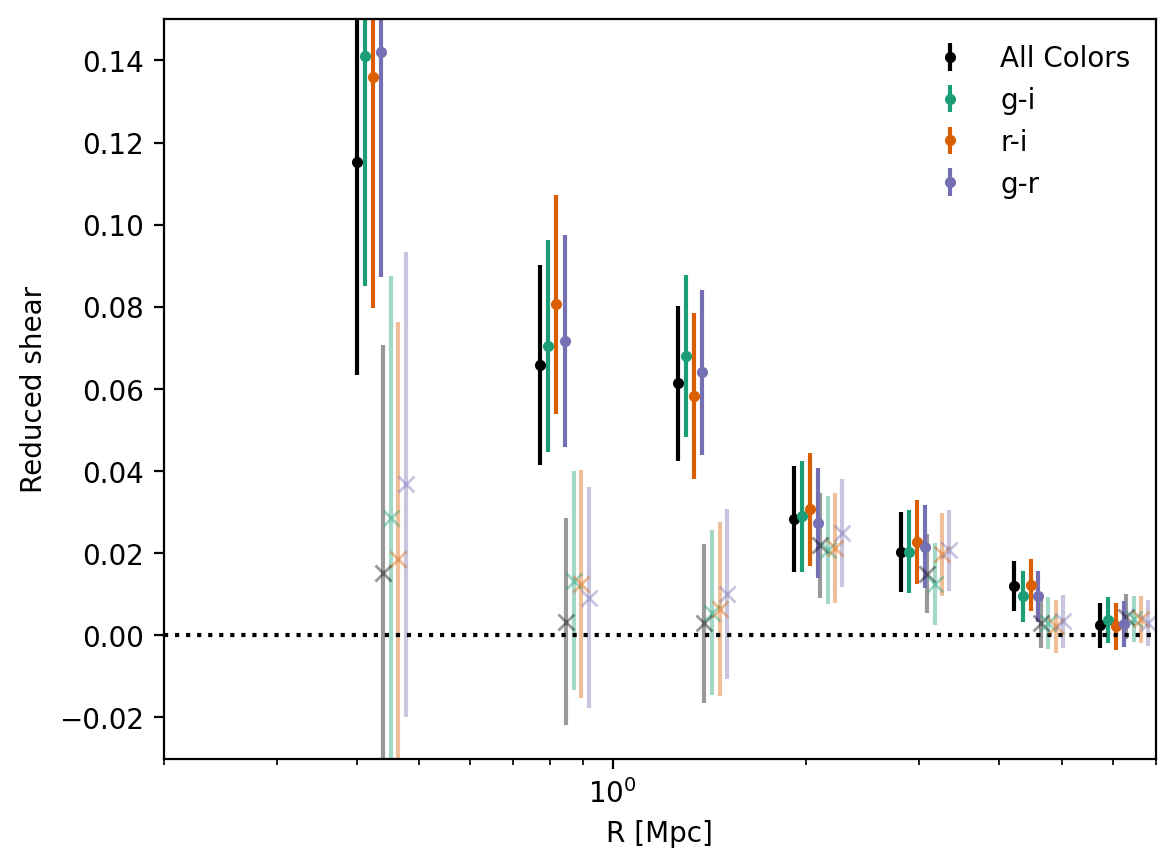

In [383]:

colors = ['#000000', '#1b9e77','#d95f02','#7570b3']
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.4)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.15])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with Color Cuts - DP1")

In [87]:
pz_types = ['bpz0.37', 'tpz0.37', 'fzboost0.37', 'knn0.37']
pz_profiles = []

for cc in pz_types:
    with open(f'./cluster_data/technote/profile_{cc}', 'rb') as f:
        profile = pickle.load(f)
        pz_profiles.append(profile.profile)

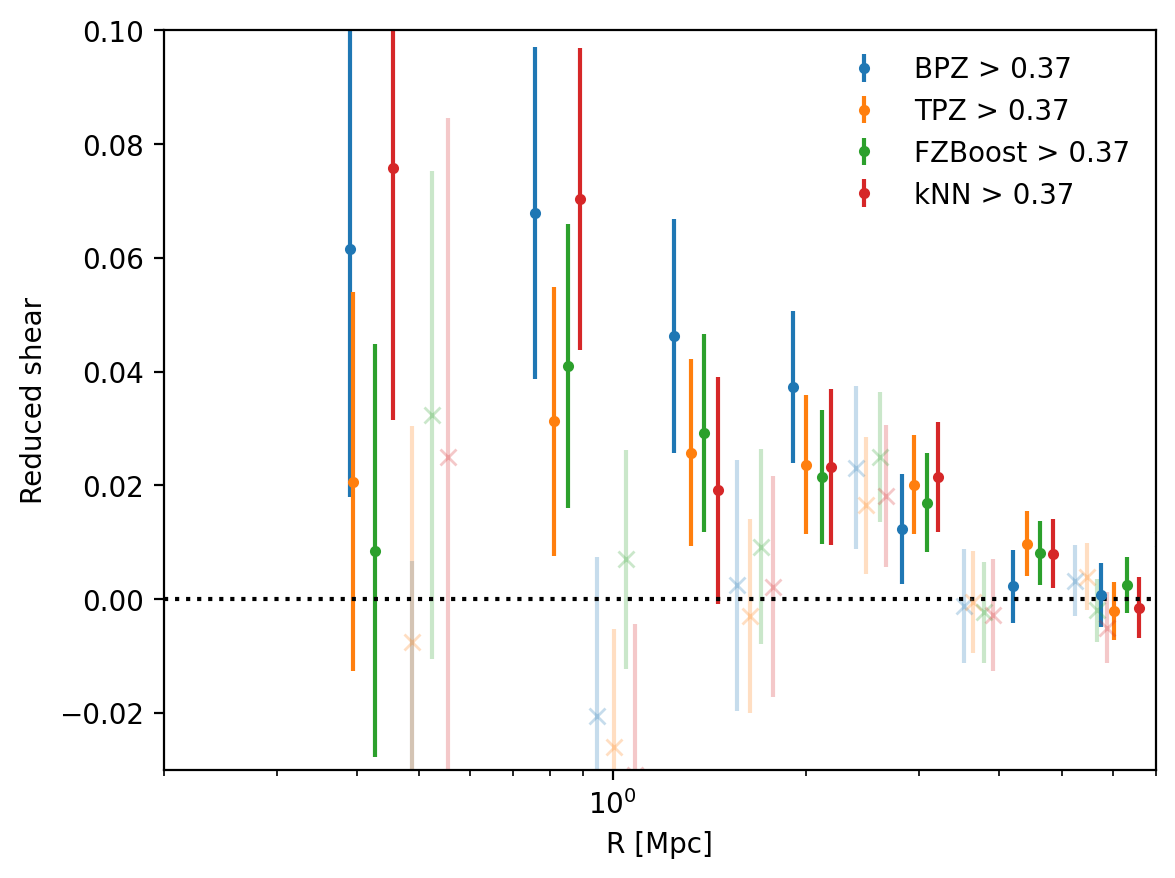

In [88]:

cmap = cm.tab10
labels = ['BPZ > 0.37', 'TPZ > 0.37',  'FZBoost > 0.37', 'kNN > 0.37']
# colors = [cmap(0), cmap(1.),cmap(.25), cmap(0.75)]
colors = [cmap(i) for i in range(4)]


for i,profile in enumerate(pz_profiles):
    plt.errorbar(profile['radius']*(1+.05*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.25+.05*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.25)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with PZ Cuts - DP1")

### Shear Ratio Test

In [206]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [199]:
# From Shenming's CLMM demo on using HSC data
def apply_shear_calibration(e1_0, e2_0, e_rms, m, c1, c2, weight):
    R = 1.0 - np.sum(weight * e_rms**2.0) / np.sum(weight)
    m_mean = np.sum(weight * m) / np.sum(weight)
    c1_mean = np.sum(weight * c1) / np.sum(weight)
    c2_mean = np.sum(weight * c2) / np.sum(weight)
    print("R, m_mean, c1_mean, c2_mean: ", R, m_mean, c1_mean, c2_mean)

    g1 = (e1_0 / (2.0 * R) - c1) / (1.0 + m_mean)
    g2 = (e2_0 / (2.0 * R) - c2) / (1.0 + m_mean)

    return g1, g2


In [207]:
algos = ['knn', 'fzboost', 'bpz', 'tpz']
bin_names = ['bin1', 'bin2']

In [262]:
algo_profiles = {}

for calib_type in algos:
    for bn in bin_names:
        print(f"Working on {calib_type} {bn}")
    
        postcuts_filename = f'technote/shear-ratio_{calib_type}{bn}_DP1.fits'
        calib_filename = f'technote/shear_ratio_calib_{calib_type}_{bn}.fits'
    
        with fits.open(f'cluster_data/{calib_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            table = Table(data)
    
        with fits.open(f'cluster_data/{postcuts_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            wl_table = Table(data)
    
        e_rms = table["ishape_hsm_regauss_derived_rms_e"]
        m = table["ishape_hsm_regauss_derived_shear_bias_m"]
        c1 = table["ishape_hsm_regauss_derived_shear_bias_c1"]
        c2 = table["ishape_hsm_regauss_derived_shear_bias_c2"]
        weight = table["ishape_hsm_regauss_derived_shape_weight"]
        # weight = np.ones(len(c1))
    
        g1, g2 = apply_shear_calibration(wl_table['i_hsmShapeRegauss_e1'], wl_table['i_hsmShapeRegauss_e2'], e_rms, m, c1, c2, weight)
    
        galcat = GCData()
        galcat['ra'] = wl_table['coord_ra']
        galcat['dec'] = wl_table['coord_dec']
        galcat['e1'] = g1
        galcat['e2'] = g2
        galcat['e_err'] = wl_table['i_hsmShapeRegauss_sigma']/2
        galcat['hsm_weight'] = weight
        galcat['id'] = np.arange(len(wl_table))
        galcat['z'] = np.zeros(len(wl_table))
        # galcat['z'] = wl_table['fzb_z_median']
    
        ra_bcg = 37.865017
        dec_bcg = 6.982205
        
        cluster_id = "Abell 360"
        gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')
    
        gc_object1.compute_tangential_and_cross_components(add=True);
        bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7]) 
     
        gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, 
                                   overwrite=True, use_weights=False, gal_ids_in_bins=False);
        algo_profiles[(calib_type, bn)] = gc_object1.profile

Working on knn bin1
R, m_mean, c1_mean, c2_mean:  0.8507852581234192 -0.0757610319317728 -1.80525784488124e-05 9.67227069517149e-06
Working on knn bin2
R, m_mean, c1_mean, c2_mean:  0.8428679777941148 -0.11161964415980455 -0.0003827883791800409 -2.2700211857176177e-05
Working on fzboost bin1
R, m_mean, c1_mean, c2_mean:  0.853753794785097 -0.056246820243661136 0.00013707294533029467 1.316323729456556e-05
Working on fzboost bin2
R, m_mean, c1_mean, c2_mean:  0.8436046997897865 -0.08931549574129578 -0.0003299916848557445 -3.483495925856697e-05
Working on bpz bin1
R, m_mean, c1_mean, c2_mean:  0.8496120311850853 -0.08070947082450636 -8.652164986558431e-05 -4.20825844448325e-06
Working on bpz bin2
R, m_mean, c1_mean, c2_mean:  0.8451347391477535 -0.08090421650003288 -0.0002830273579807718 -5.971653608379527e-06
Working on tpz bin1
R, m_mean, c1_mean, c2_mean:  0.8523100644928511 -0.05986017122355586 2.983781004426725e-05 1.1427323101747962e-06
Working on tpz bin2
R, m_mean, c1_mean, c2_mea

In [267]:
gc_object1.profile

GCData(cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc', columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l)

In [268]:
plot_means_t = np.zeros((len(algos), 2))
plot_errs_t = np.zeros((len(algos), 2))

plot_means_x = np.zeros((len(algos), 2))
plot_errs_x = np.zeros((len(algos), 2))

for i,alg in enumerate(algos):
    for j, bn in enumerate(bin_names):
        profile = algo_profiles[(alg, bn)]
        plot_means_t[i,j] = profile['gt'][1]
        plot_errs_t[i,j] = profile['gt_err'][1]
        plot_means_x[i,j] = profile['gx'][1]
        plot_errs_x[i,j] = profile['gx_err'][1]

Text(0.02, 0.5, 'Reduced shear')

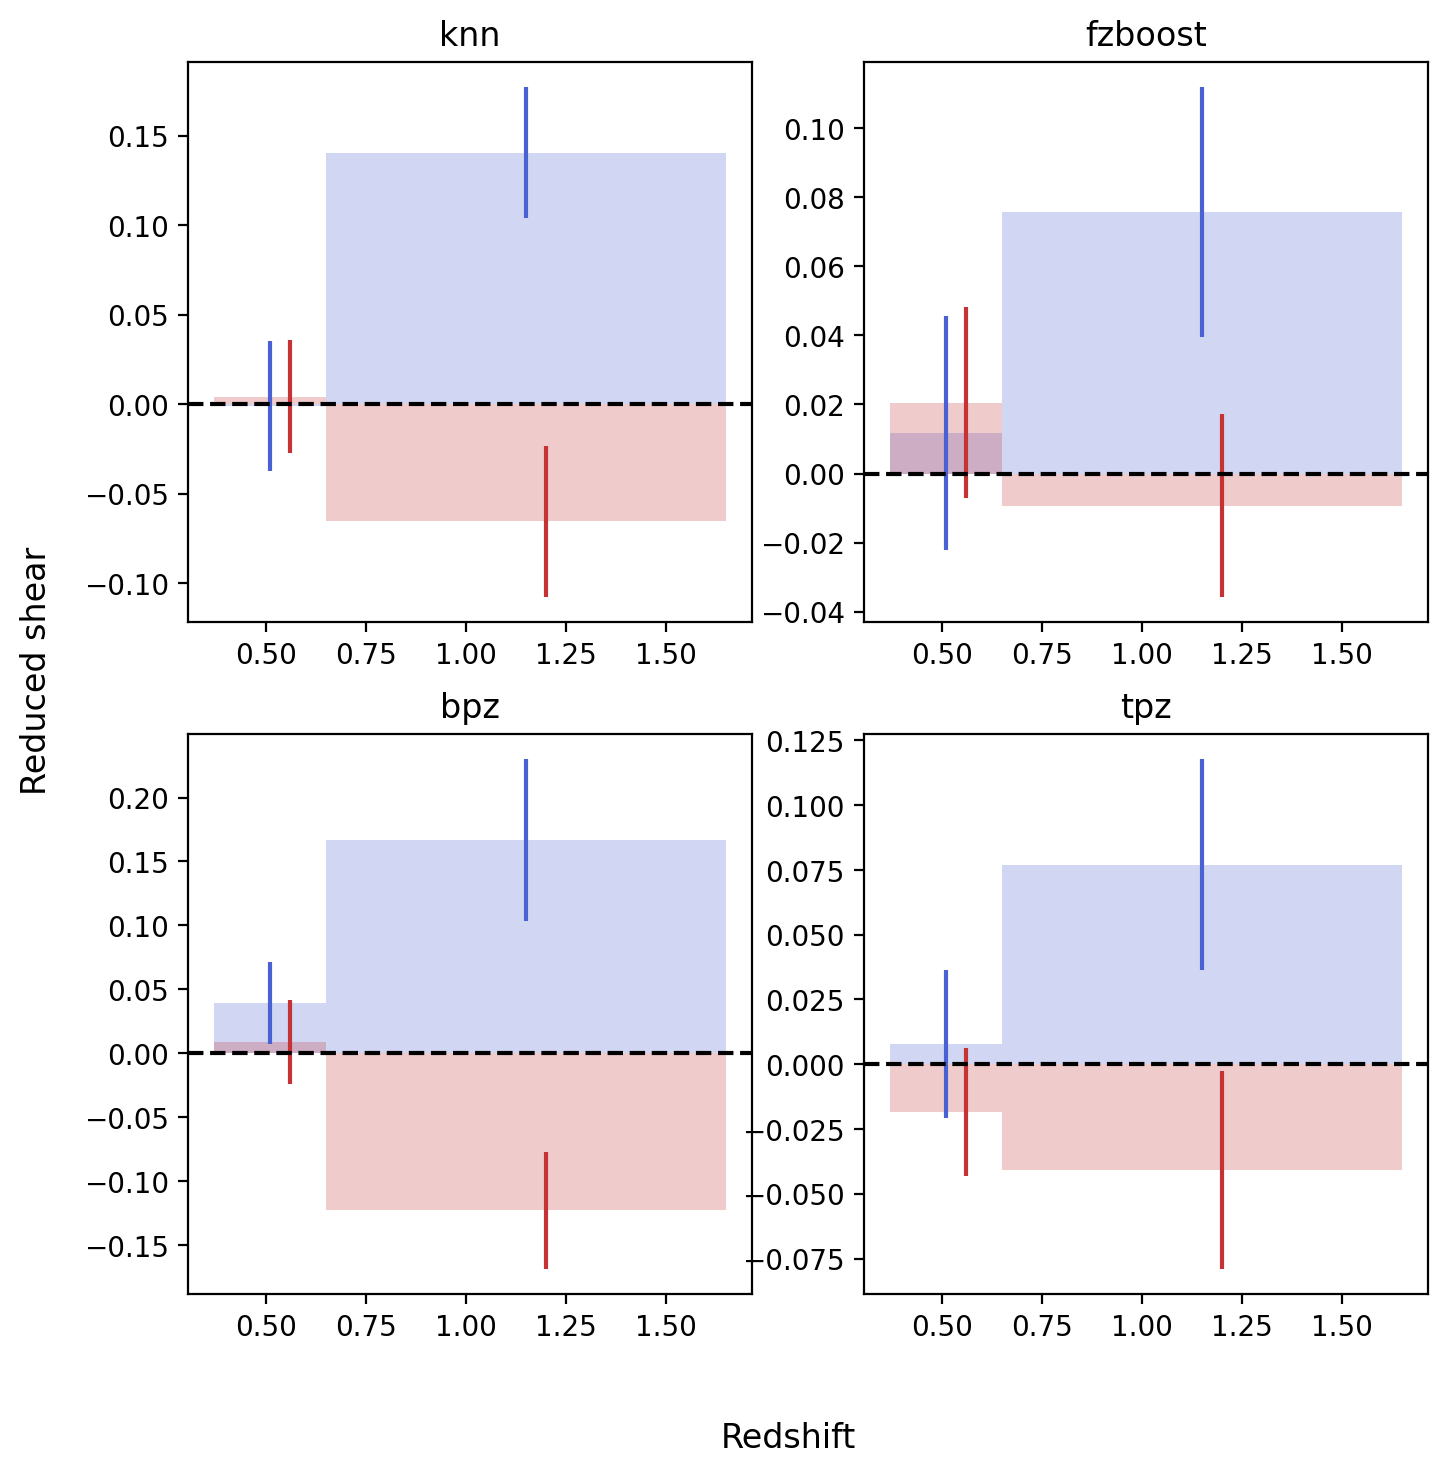

In [274]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51, 1.15], y=plot_means_t[i], yerr=plot_errs_t[i], color=cmap(0.05), ls='')
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51+0.05, 1.15+0.05], y=plot_means_x[i], yerr=plot_errs_x[i], color=cmap(0.95), ls='')
    axes[ix, iy].set_title(algos[i])
    # axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')
fig.supxlabel("Redshift")
fig.supylabel("Reduced shear")

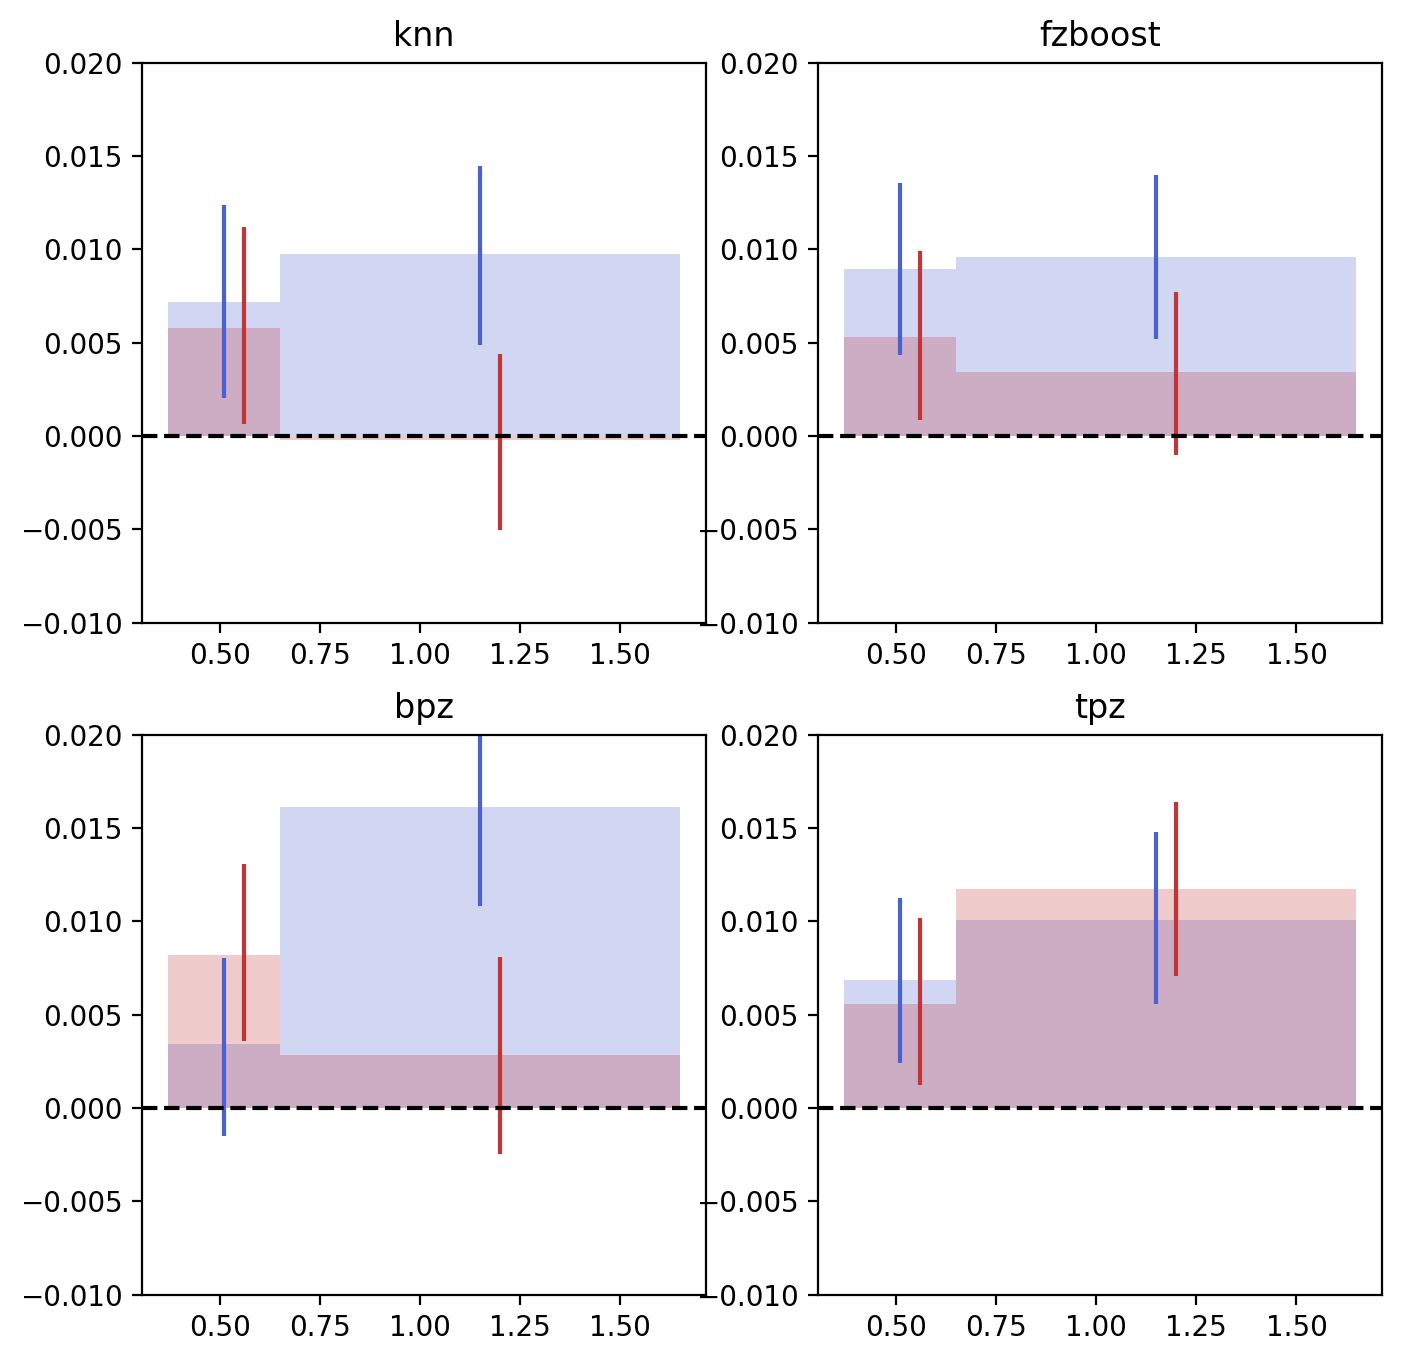

In [261]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].vlines([0.51, 1.15], ymin=plot_errs_t[i,:,0], ymax=plot_errs_t[i,:,1], color=cmap(0.05))
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].vlines([0.51+.05, 1.15+.05], ymin=plot_errs_x[i,:,0], ymax=plot_errs_x[i,:,1], color=cmap(0.95))
    axes[ix, iy].set_title(algos[i])
    axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')

## Data Summary Plot

Assuming the Butler cells were ran up-to creating the preclean_table

In [512]:
# clean_table2 = preclean_table[preclean_filt(preclean_table)]
clean_table = preclean_table[preclean_flux_filt(preclean_table)]

In [513]:
clean_table = apply_redsequence(clean_table)

In [514]:
wl_filt = get_wlfilt(clean_table, mag_lim=28, bright_lim=1, SNR=0)
wl_table = clean_table[wl_filt]

After WL cuts: 28305


In [515]:
imag_table = wl_table[wl_table['i_cModel_mag'] < 23.76]
Nimag_table = len(imag_table)

In [516]:
SNR_cut14 = imag_table[imag_table['i_cModelFlux']/imag_table['i_cModelFluxErr'] > 14]
SNR_cut10 = imag_table[imag_table['i_cModelFlux']/imag_table['i_cModelFluxErr'] > 10]
Nsnr = len(SNR_cut10)
print((Nimag_table-Nsnr)/Nimag_table)

0.031313967161708985


In [517]:
rs_cut = SNR_cut10[~SNR_cut10['all_redseq']]

Text(0.5, 1.0, 'SV 38_7')

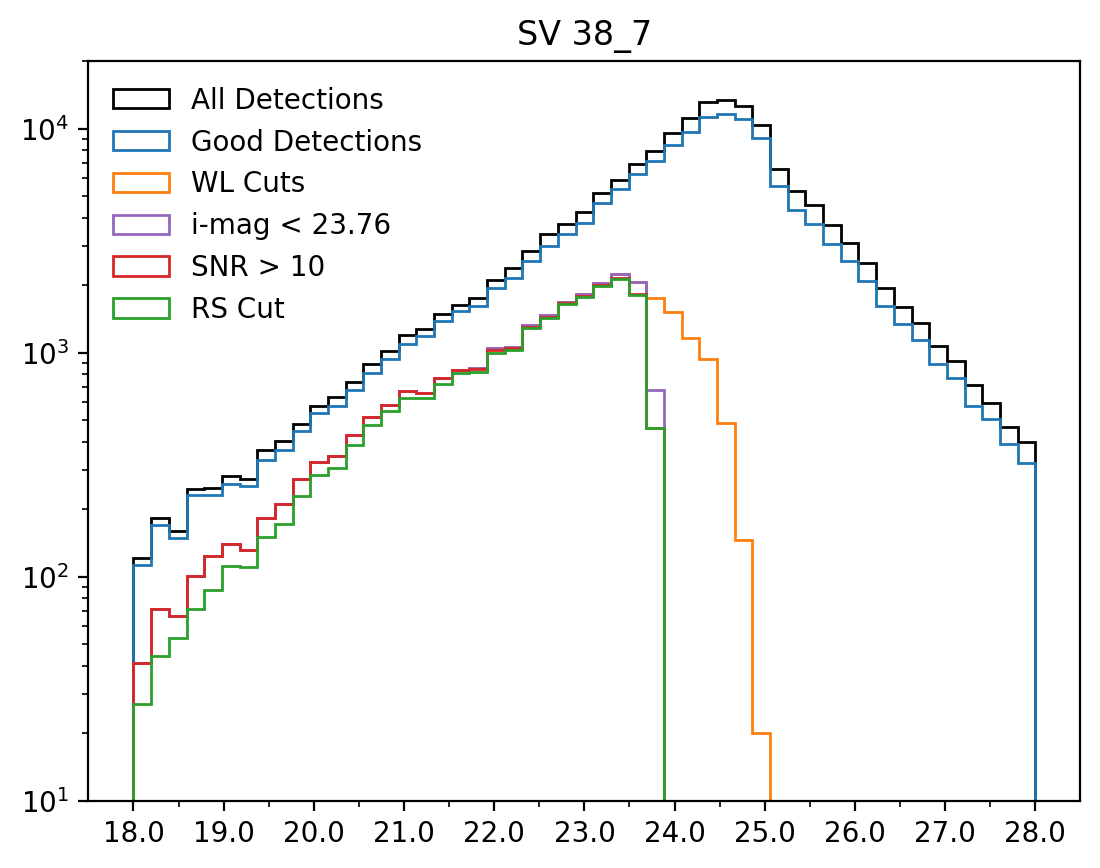

In [518]:
major_xticks = np.arange(18, 28.5, 1)
minor_xticks = np.arange(18.5, 28.5, 1)

cmap = cm.tab10

plt.hist(preclean_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="All Detections", color='k')
plt.hist(clean_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="Good Detections", color=cmap(0))
plt.hist(wl_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="WL Cuts", color=cmap(1))
plt.hist(imag_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="i-mag < 23.76", color=cmap(4))
plt.hist(SNR_cut10['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="SNR > 10", color=cmap(3))
# plt.hist(SNR_cut14['i_cModel_mag'], range=(18, 28), histtype='step', bins=31, label="SNR > 14", color=cmap(4))
plt.hist(rs_cut['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="RS Cut", color=cmap(2))
plt.xticks(major_xticks, major_xticks, minor=False)
plt.xticks(minor_xticks, minor=True)
plt.ylim(1e1, 2e4)
plt.legend(frameon=False)
plt.semilogy()
plt.title("SV 38_7")

In [461]:
# preclean_ecdfs

In [488]:
clean_ecdfs, preclean_ecdfs = load_pz_photomdata(tracts=ecdfs_tracts, columns=ecdfs_object_req_cols)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [490]:
clean_ecdfs = apply_redsequence(clean_ecdfs)

In [492]:
wl_filt = get_wlfilt(clean_ecdfs, mag_lim=28, bright_lim=1, SNR=0, apply_sep=False)
ecdfs_wl_table = clean_ecdfs[wl_filt]

After WL cuts: 82369


In [494]:
ecdfs_imag_table = ecdfs_wl_table[ecdfs_wl_table['i_cModel_mag'] < 23.76]
Nimag_table = len(ecdfs_imag_table)

In [495]:
ecdfs_SNR_cut14 = ecdfs_imag_table[ecdfs_imag_table['i_cModelFlux']/ecdfs_imag_table['i_cModelFluxErr'] > 14]
ecdfs_SNR_cut10 = ecdfs_imag_table[ecdfs_imag_table['i_cModelFlux']/ecdfs_imag_table['i_cModelFluxErr'] > 10]
Nsnr = len(ecdfs_SNR_cut10)
print((Nimag_table-Nsnr)/Nimag_table)

0.004503091674881262


In [503]:
ecdfs_rs_cut = ecdfs_SNR_cut10[~ecdfs_SNR_cut10['all_redseq']]

Text(0.5, 1.0, 'ECDFS')

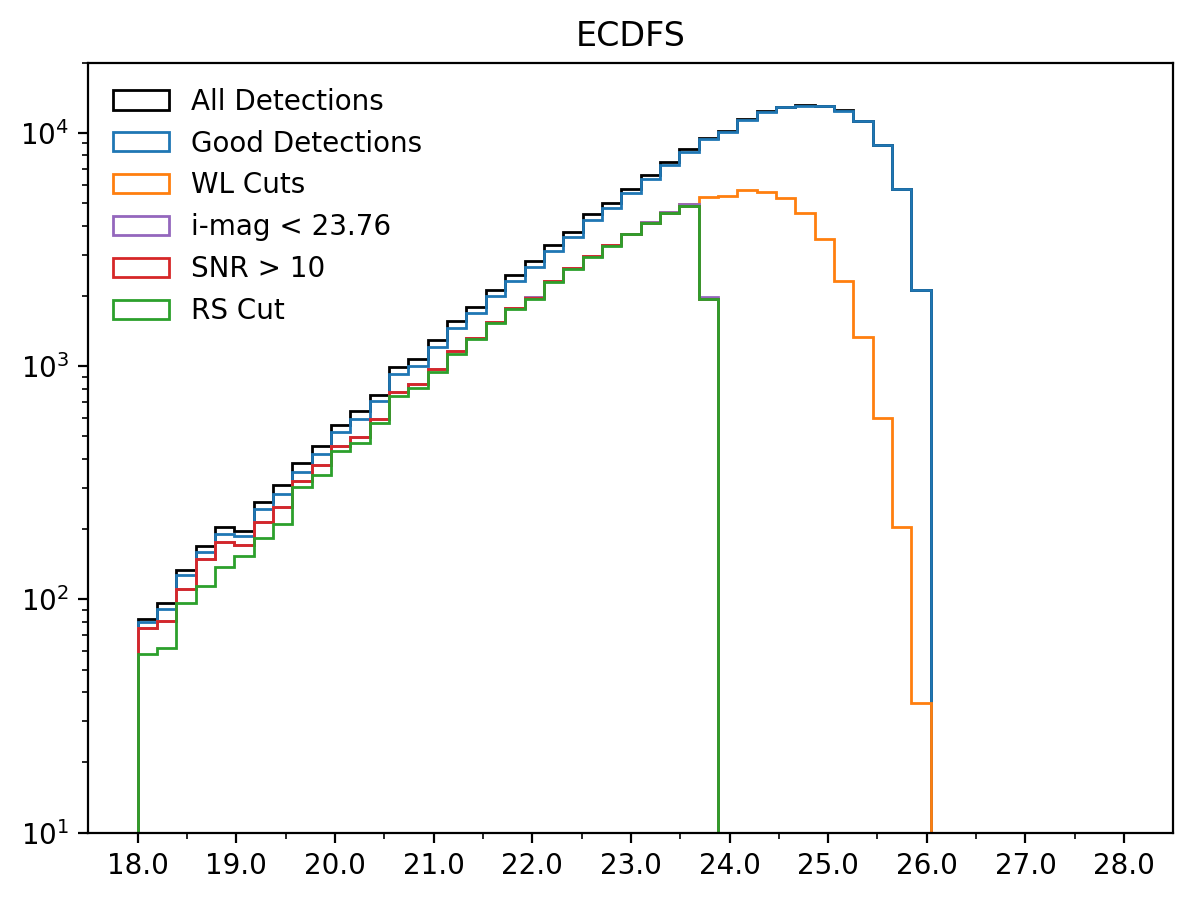

In [510]:
fig, ax = plt.subplots(1, figsize=(7,5))

major_xticks = np.arange(18, 28.5, 1)
minor_xticks = np.arange(18.5, 28.5, 1)

cmap = cm.tab10

ax.hist(preclean_ecdfs['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="All Detections", color='k')
ax.hist(clean_ecdfs['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="Good Detections", color=cmap(0))
ax.hist(ecdfs_wl_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="WL Cuts", color=cmap(1))
ax.hist(ecdfs_imag_table['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="i-mag < 23.76", color=cmap(4))
ax.hist(ecdfs_SNR_cut10['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="SNR > 10", color=cmap(3))
# plt.hist(SNR_cut14['i_cModel_mag'], range=(18, 28), histtype='step', bins=31, label="SNR > 14", color=cmap(4))
ax.hist(ecdfs_rs_cut['i_cModel_mag'], range=(18, 28), histtype='step', bins=51, label="RS Cut", color=cmap(2))
ax.set_xticks(major_xticks, major_xticks, minor=False)
ax.set_xticks(minor_xticks, minor=True)
ax.set_ylim(1e1, 2e4)
ax.legend(frameon=False)
ax.semilogy()
ax.set_title("ECDFS")

In [434]:
icut_clean = clean_table[clean_table['i_cModel_mag'] < 23.8]


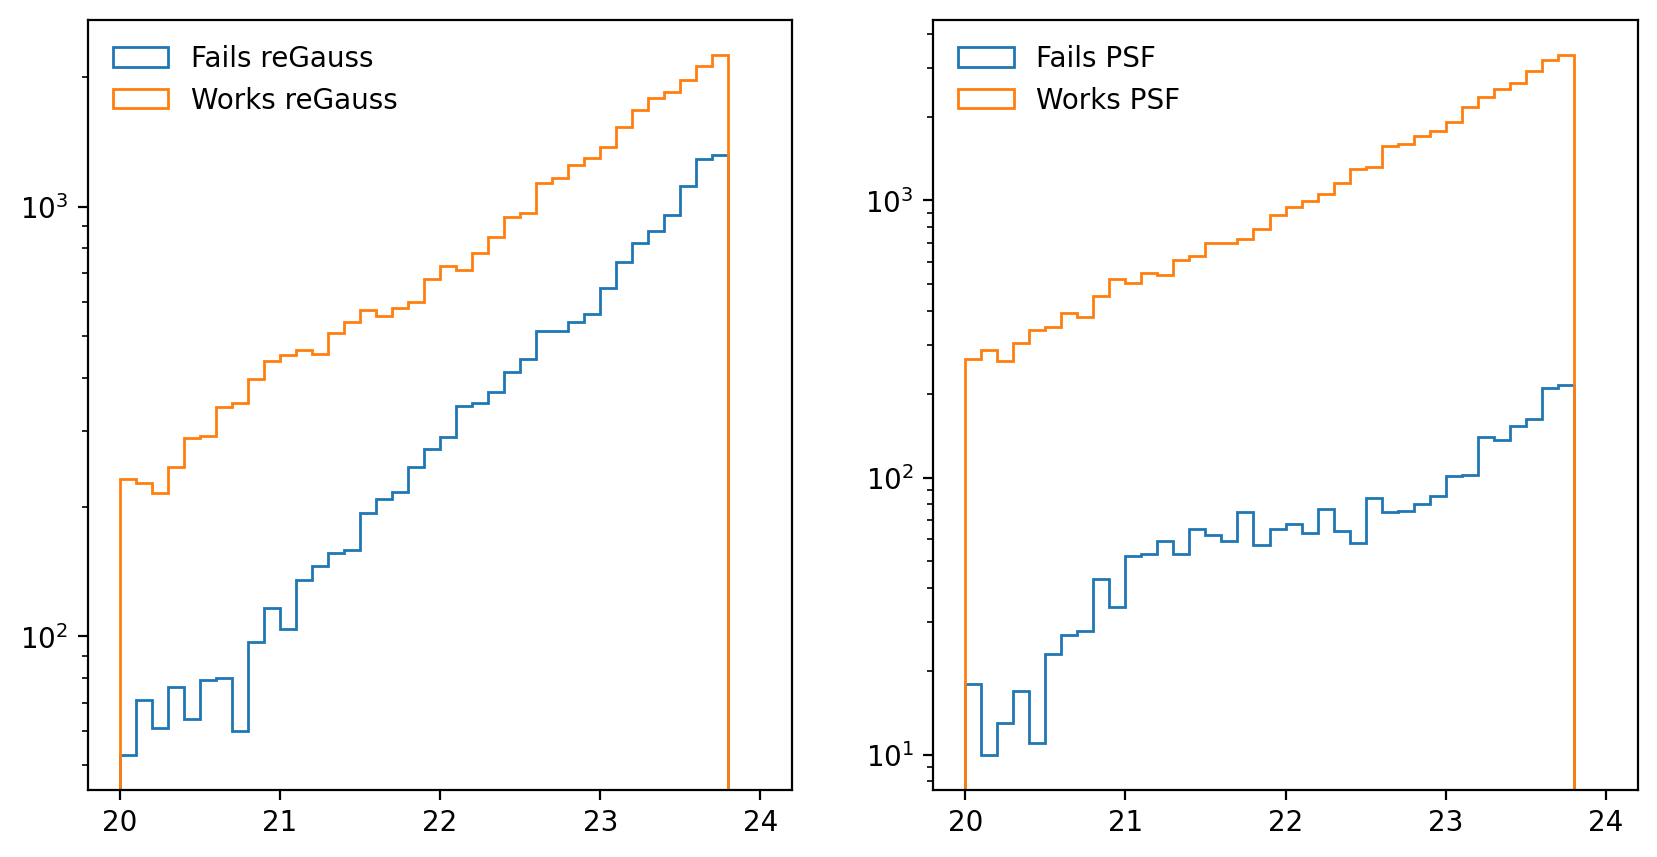

In [459]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


ax[0].hist(icut_clean['i_cModel_mag'][icut_clean['i_hsmShapeRegauss_flag']],
         range=(20, 24), bins=40, histtype='step', label="Fails reGauss")
ax[0].hist(icut_clean['i_cModel_mag'][~icut_clean['i_hsmShapeRegauss_flag']],
         range=(20, 24), bins=40, histtype='step', label="Works reGauss")
ax[0].semilogy()
ax[0].legend(frameon=False)

ax[1].hist(icut_clean['i_cModel_mag'][icut_clean['i_iPSF_flag']],
         range=(20, 24), bins=40, histtype='step', label="Fails PSF")
ax[1].hist(icut_clean['i_cModel_mag'][~icut_clean['i_iPSF_flag']],
         range=(20, 24), bins=40, histtype='step', label="Works PSF")

ax[1].semilogy()
ax[1].legend(frameon=False)

#### Playground

In [29]:
# pz_butler = Butler("/repo/DP1", collections=["LSSTComCam/runs/DRP/DP1/pz/DM-51523/gold/baseline/v1"])

# dataRefs = pz_butler.query_datasets("pz_estimate_fzboost")

# pz_data = pz_butler.get(dataRefs[0])



# dp1_catalog, _ = load_pz_photomdata(ddir='/global/cfs/cdirs/lsst/groups/PZ/DP1/data/dp1_v29.0.0_gold/',
#                                     suffix='pq')


# test_filt = dp1_catalog['sep'] < 0.5

# # test_pdfs = get_pdfs('dnf', test_filt, pz_dir='/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_baseline')

# # kale = pd.read_parquet('/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet')
# kale = pd.read_parquet('/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet')

# np.sum(np.isin(kale['objectId'], dp1_catalog['objectId']))

# np.sum(~np.isin(kale['objectId'], dp1_catalog['objectId']))

# pdfs = qp.read('/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1/data/gold_baseline/output_estimate_knn.hdf5')

# pdfs

# xs = np.arange(0, 3, 0.01)

# t1 = pdfs[0].pdf(xs)

# pdfs[0].data

# plt.plot(xs, t1, '.')

# pz_test = Table.read('https://data.lsdb.io/hats/dp1/object_photoz.parquet')
